In [1]:
import numpy as np
import glob
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import mplhep
import matplotlib.colors as mcolors
import matplotlib.scale

mplhep.style.use(mplhep.style.CMS)

# Chip 9 plots

## Loading all data

In [17]:
def jsonload(fname):
    with open(fname) as jsonfile:
        try:
            return json.load(jsonfile)
        except Exception:
            print(fname)

In [18]:
fdir = "/Users/alexcampbell/Documents/Research/Fermilab/TID/Chip7F_data"
fnames = list(np.sort(glob.glob(f"{fdir}/report*.json")))
all_files = fnames.copy()

In [4]:
to_remove = [
    f"{fdir}/report_2023-08-23T08:50:47.322524.json",
    f"{fdir}/report_2023-08-23T09:06:56.860898.json",
    f"{fdir}/report_2023-08-23T09:23:07.950039.json",
    f"{fdir}/report_2023-08-23T09:39:33.918227.json",
    f"{fdir}/report_2023-08-23T09:56:56.482843.json",
    f"{fdir}/report_2023-08-23T10:13:57.320867.json",
]
for i in range(len(all_files)):
    if all_files[i] in to_remove:
        fnames.remove(fnames[i])

In [19]:
data = [jsonload(fname) for fname in fnames]

for i in range(len(data)):
    if data[i] == None:
        data.remove(data[i])

In [127]:
data = data[:116]

In [20]:
goodTimes = []

for i in range(len(fnames)):
    tprim = fnames[i].split("_")[-1]
    timeb = tprim.split(".json")[0]
    times = timeb.split("T")
    timegood = times[0]+" "+times[1]
    goodTimes.append(timegood)
    
goodTimes = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f") for x in goodTimes]
delTimes = [x - goodTimes[0] for x in goodTimes]
delTimes = np.array(delTimes)
delTimes = delTimes/timedelta(minutes=1)
rad_dose = 9.2/60
megarad_dose = rad_dose*delTimes


In [154]:
megarad_dose = megarad_dose[:115]

In [21]:
megarad_dose_plots = np.array(list(megarad_dose)+[(megarad_dose[-1]-megarad_dose[-2])+megarad_dose[-1]])

In [13]:
def shift_colormap(cmap, start=0, midpoint=0.5, stop=1, name='shiftedcmap'):
    cdict = {'red': [], 'green': [], 'blue': [], 'alpha': []}
    reg_index = np.linspace(start, stop, 257)
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False),
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])
    
    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)
        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
        
    newmap = mpl.colors.LinearSegmentedColormap(name, cdict)
    
    return newmap

newmap = shift_colormap(mpl.colormaps['bwr'],start=0.5,name="shift1")


# BIST

In [156]:
voltages = []
ping_pong_bist_result = []
ob_bist_result = []
for i in range(len(data)):
    for j in range(len(data[i]['tests'])):
        if "metadata" in data[i]['tests'][j]:
            if "ping_pong_bist_result" in data[i]['tests'][j]['metadata']:
                ping_pong_bist_result.append(data[i]['tests'][j]['metadata']['ping_pong_bist_result'])
                voltages.append(data[i]['tests'][j]['metadata']['voltage'])
                ob_bist_result.append(data[i]['tests'][j]['metadata']['ob_bist_result'])

ob_bist_results = dict.fromkeys(list(np.unique(np.array(voltages))))
ping_pong_bist_results = dict.fromkeys(list(np.unique(np.array(voltages))))
for key in ob_bist_results.keys():
    ob_bist_results[key] = [ob_bist_result[i] for i in range(len(voltages)) if voltages[i]==key]
for key in ping_pong_bist_results.keys():
    ping_pong_bist_results[key] = [ping_pong_bist_result[i] for i in range(len(voltages)) if voltages[i]==key]

print(len(ping_pong_bist_results[1.08]))

115


In [157]:
pp_bist = []
for key in ping_pong_bist_results.keys():
    alexTemp1 = []
    for i in range(len(ping_pong_bist_results[1.08])):
        alexTemp = []
        for j in range(4):
            for k in range(12):
                alexTemp.append((ping_pong_bist_results[key][i][j]>> k) & 0b1)
        alexTemp1.append(alexTemp)
    pp_bist.append(alexTemp1)
pp_bist = np.array(pp_bist)
for i in range(len(pp_bist)):
    pp_bist[i] = pp_bist[i].reshape(-1,48)
    pp_bist[i] = pp_bist[i][:,[range(i,48,12) for i in range(12)]].reshape(-1,48)
    
ob_bist = []
for key in ob_bist_results.keys():
    alexTemp1 = []
    for i in range(len(ob_bist_results[1.08])):
        alexTemp = []
        for j in range(4):
            for k in range(12):
                alexTemp.append((ob_bist_results[key][i][j]>> k) & 0b1)
        alexTemp1.append(alexTemp)
    ob_bist.append(alexTemp1)
ob_bist = np.array(ob_bist)
for i in range(len(ob_bist)):
    ob_bist[i] = ob_bist[i].reshape(-1,48)
    ob_bist[i] = ob_bist[i][:,[range(i,48,12) for i in range(12)]].reshape(-1,48)

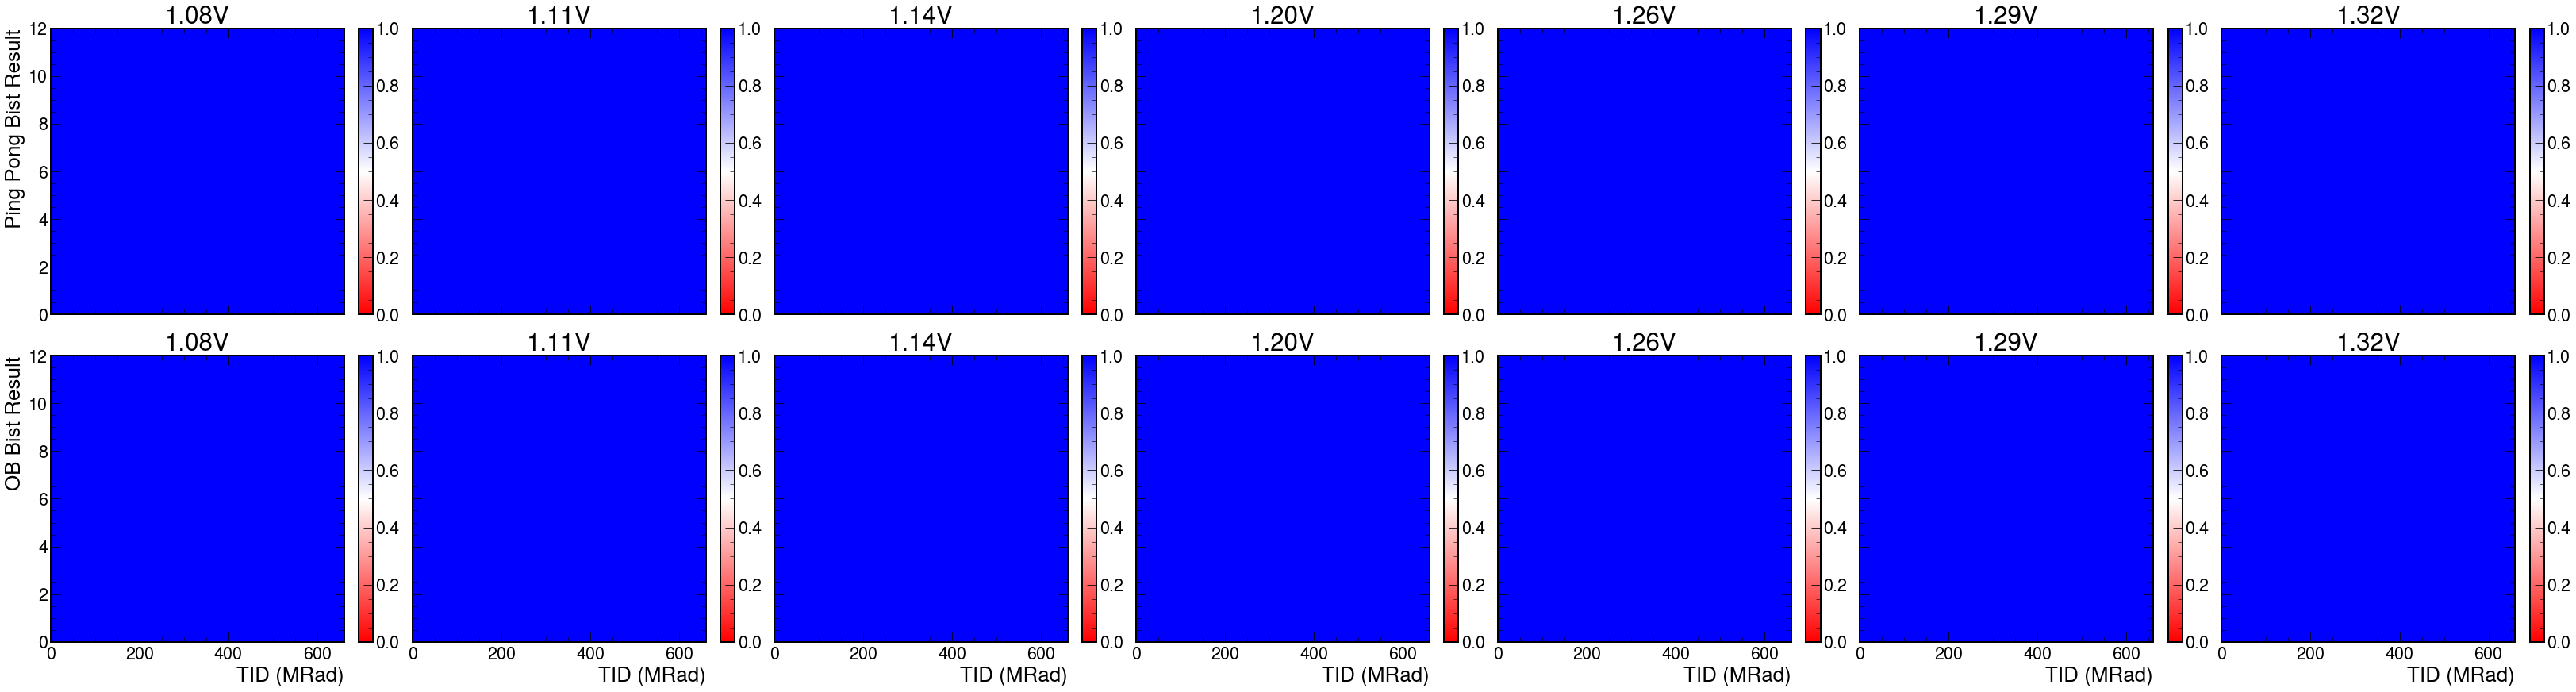

In [135]:
fig,axs=plt.subplots(figsize=(45,12),ncols=7,nrows=2, layout="constrained")

volts = [8,11,14,20,26,29,32]
for j in range(7):
    for i in range(2):
        if i == 0:
            nTrials = len(pp_bist[j])
            a,b=np.meshgrid(megarad_dose,np.arange(0,12,(12/48)))
            rand = nTrials + 1
            chData = pp_bist[j]
            h = axs[i,j].hist2d(a.flatten(),b.flatten(),weights=chData.T.flatten(),bins=(megarad_dose_plots ,np.arange(0,13,(12/48))),cmap='bwr_r')
            axs[i,j].set_ylim(0,12)
            axs[i,j].set_xlim(0,660)
            if volts[j] ==8:
                axs[i,j].set_title(f"1.0{volts[j]}V")
            else:
                axs[i,j].set_title(f"1.{volts[j]}V")
            axs[i,j].set_ylabel('Ping Pong Bist Result')
            axs[i,j].set_xlabel('TID (MRad)')
            cb=fig.colorbar(h[3], ax = axs[i,j])

        if i == 1:
            nTrials = len(ob_bist[j])
            a,b=np.meshgrid(megarad_dose,np.arange(0,12,(12/48)))
            rand = nTrials + 1
            chData = ob_bist[j]
            h = axs[i,j].hist2d(a.flatten(),b.flatten(),weights=chData.T.flatten(),bins=(megarad_dose_plots,np.arange(0,13,(12/48))),cmap='bwr_r')
            axs[i,j].set_ylim(0,12)
            axs[i,j].set_xlim(0,660)
            if volts[j] ==8:
                axs[i,j].set_title(f"1.0{volts[j]}V")
            else:
                axs[i,j].set_title(f"1.{volts[j]}V")
            axs[i,j].set_ylabel('OB Bist Result')
            axs[i,j].set_xlabel('TID (MRad)')
            cb=fig.colorbar(h[3], ax = axs[i,j])

for ax in axs.flat:
    ax.label_outer()
fig.savefig("./ping_pong_and_ob_bist_results.jpg")

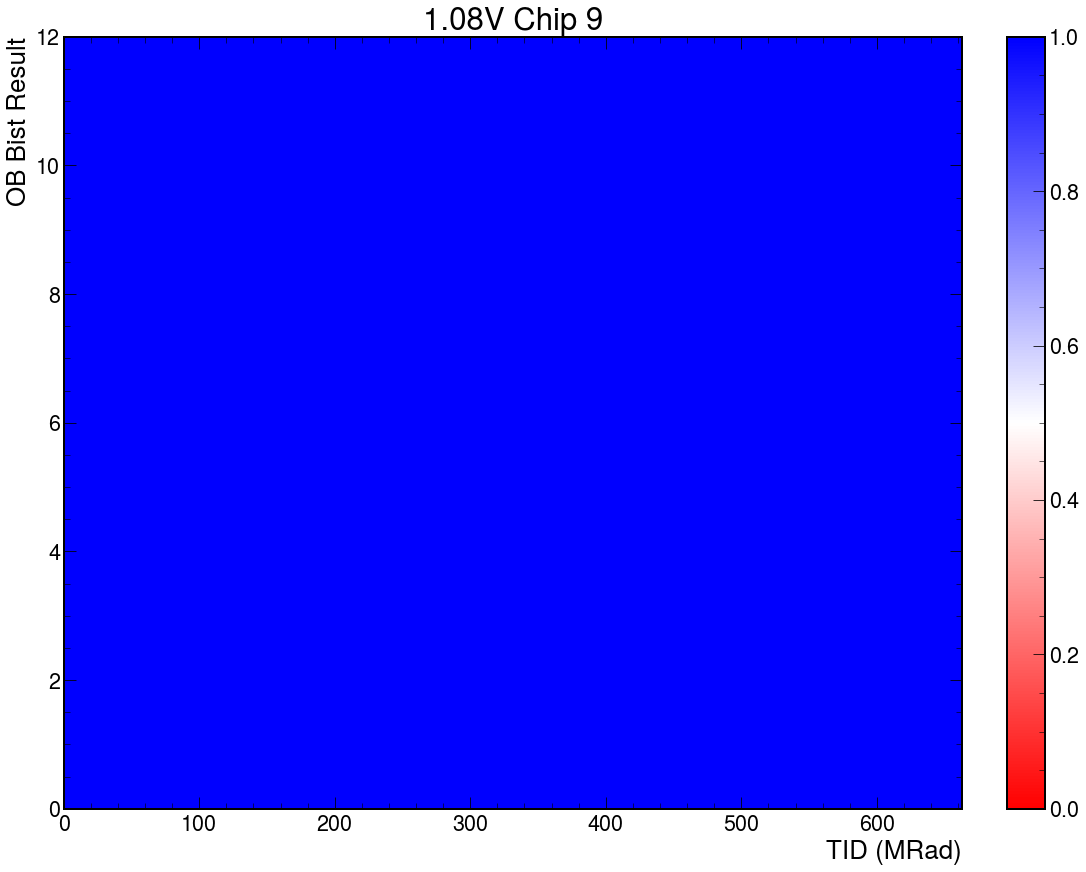

In [159]:
ncols = 2
nrows = 1
fig,axs=plt.subplots(figsize=(15,12),layout="constrained")

    

nTrials = len(ob_bist[0])
a,b=np.meshgrid(megarad_dose,np.arange(0,12,(12/48)))
rand = nTrials + 1
chData = ob_bist[0]
h = axs.hist2d(a.flatten(),b.flatten(),weights=chData.T.flatten(),bins=(megarad_dose_plots ,np.arange(0,13,(12/48))),cmap='bwr_r')
axs.set_ylim(0,12)
if volts[0] ==8:
    axs.set_title(f"1.0{volts[0]}V Chip 9")
else:
    axs.set_title(f"1.0{volts[0]}V Chip 9")
axs.set_ylabel('OB Bist Result')
axs.set_xlabel('TID (MRad)')
cb=fig.colorbar(h[3], ax = axs)

fig.savefig("./ob_1_08_chip9.jpg", transparent=False)

In [36]:
len(pp_bist[0])

115

# Automatic Cap Bank setting vs time

In [62]:
def cap_bank_value(frequency):
    automatic_cap = []
    voltages = []
    timestamps = []
    for i in range(len(data)):
        for j in range(len(data[i]['tests'])):
            if "metadata" in data[i]['tests'][j]:
                if "automatic_capbank_setting" in data[i]['tests'][j]['metadata']:
                    if f"-{frequency}]" in data[i]['tests'][j]['nodeid']:
                        automatic_cap.append(data[i]['tests'][j]['metadata']['automatic_capbank_setting'])
                        voltages.append(data[i]['tests'][j]['metadata']['voltage'])
                        timestamps.append(data[i]['tests'][j]['metadata']['Timestamp'][0])

    allowed_cap_bank_vals=np.array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
                                    13,  14,  15,  24,  25,  26,  27,  28,  29,  30,  31,  56,  57,
                                    58,  59,  60,  61,  62,  63, 120, 121, 122, 123, 124, 125, 126,
                                    127, 248, 249, 250, 251, 252, 253, 254, 255, 504, 505, 506,       507,
                                    508, 509, 510, 511])
    for i in range (len(automatic_cap)):
            for j in range(56):
                if automatic_cap[i] == allowed_cap_bank_vals[j]:
                    automatic_cap[i] = j

    automatic_cap_results = dict.fromkeys(list(np.unique(np.array(voltages))))
    timestamps_results = dict.fromkeys(list(np.unique(np.array(voltages))))
    for key in automatic_cap_results.keys():
        automatic_cap_results[key] = [automatic_cap[i] for i in range(len(voltages)) if voltages[i]==key]
    for key in timestamps_results.keys():
        timestamps_results[key] = [timestamps[i] for i in range(len(voltages)) if voltages[i]==key]
    megarad_dose = dict.fromkeys(list(np.unique(np.array(voltages)))) 

    keylist = [1.08,1.11,1.14,1.20,1.26,1.29,1.32]
    for i in range(len(keylist)):
        timestamps_results[keylist[i]] = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f") for x in timestamps_results[keylist[i]] ]
        delTimes = [x - goodTimes[0] for x in timestamps_results[keylist[i]]]
        delTimes = np.array(delTimes)
        delTimes = delTimes/timedelta(minutes=1)
        rad_dose = 9.2/60
        megarad_dose[keylist[i]] = rad_dose*delTimes

    fig,axs=plt.subplots(figsize=(70,12),ncols=7,nrows=1, layout="constrained")

    keylist = [1.08,1.11,1.14,1.20,1.26,1.29,1.32]
    for i in range(len(keylist)):
        axs[i].scatter(megarad_dose[keylist[i]],automatic_cap_results[keylist[i]])
        axs[i].set_title(f"{keylist[i]}V - {frequency} MHz")
        axs[i].set_ylabel('Automatic Capbank Selection')
        axs[i].set_xlabel('TID (MRad)')
        axs[i].set_xlim(0,660)
        axs[i].set_ylim(42,50)
        axs[i].grid(which='minor', alpha=0.2, color='b', linestyle='--', linewidth=.3)
        axs[i].grid(which='major', alpha=0.2, color='b', linestyle='--', linewidth=.6)
            
    for ax in axs.flat:
        ax.label_outer()

    fig.savefig(f"./automatic_capbank_selection_results_{frequency}.jpg")
    # return axs

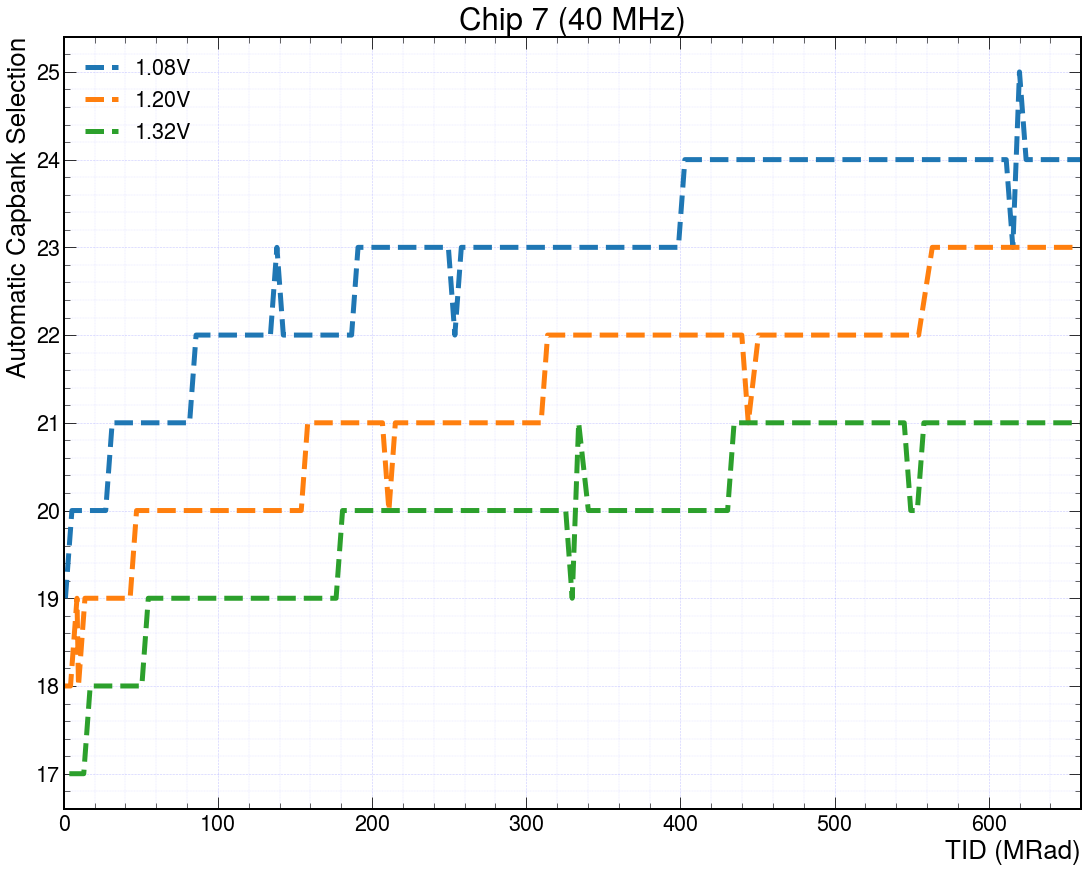

In [59]:
automatic_cap = []
frequency = 40
voltages = []
timestamps = []
for i in range(len(data)):
    for j in range(len(data[i]['tests'])):
        if "metadata" in data[i]['tests'][j]:
            if "automatic_capbank_setting" in data[i]['tests'][j]['metadata']:
                if f"-{frequency}]" in data[i]['tests'][j]['nodeid']:
                    automatic_cap.append(data[i]['tests'][j]['metadata']['automatic_capbank_setting'])
                    voltages.append(data[i]['tests'][j]['metadata']['voltage'])
                    timestamps.append(data[i]['tests'][j]['metadata']['Timestamp'][0])

allowed_cap_bank_vals=np.array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
                                13,  14,  15,  24,  25,  26,  27,  28,  29,  30,  31,  56,  57,
                                58,  59,  60,  61,  62,  63, 120, 121, 122, 123, 124, 125, 126,
                                127, 248, 249, 250, 251, 252, 253, 254, 255, 504, 505, 506,       507,
                                508, 509, 510, 511])
for i in range (len(automatic_cap)):
        for j in range(56):
            if automatic_cap[i] == allowed_cap_bank_vals[j]:
                automatic_cap[i] = j

automatic_cap_results = dict.fromkeys(list(np.unique(np.array(voltages))))
timestamps_results = dict.fromkeys(list(np.unique(np.array(voltages))))
for key in automatic_cap_results.keys():
    automatic_cap_results[key] = [automatic_cap[i] for i in range(len(voltages)) if voltages[i]==key]
for key in timestamps_results.keys():
    timestamps_results[key] = [timestamps[i] for i in range(len(voltages)) if voltages[i]==key]
megarad_dose = dict.fromkeys(list(np.unique(np.array(voltages)))) 

keylist = [1.08,1.11,1.14,1.20,1.26,1.29,1.32]
for i in range(len(keylist)):
    timestamps_results[keylist[i]] = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f") for x in timestamps_results[keylist[i]] ]
    delTimes = [x - goodTimes[0] for x in timestamps_results[keylist[i]]]
    delTimes = np.array(delTimes)
    delTimes = delTimes/timedelta(minutes=1)
    rad_dose = 9.2/60
    megarad_dose[keylist[i]] = rad_dose*delTimes

fig,axs=plt.subplots(figsize=(15,12), layout="constrained")

keylist = [1.08,1.11,1.14,1.20,1.26,1.29,1.32]

axs.plot(megarad_dose[1.08],automatic_cap_results[1.08], label = "1.08V" , linestyle="dashed",linewidth=5.0)
axs.plot(megarad_dose[1.20],automatic_cap_results[1.20], label = "1.20V", linestyle="dashed",linewidth=5.0)
axs.plot(megarad_dose[1.32],automatic_cap_results[1.32], label = "1.32V", linestyle="dashed",linewidth=5.0)
axs.set_title(f"Chip 7 (40 MHz)")
axs.set_title(f"Chip 7 (40 MHz)")
axs.set_title(f"Chip 7 (40 MHz)")
axs.set_ylabel('Automatic Capbank Selection')
axs.set_xlabel('TID (MRad)')
axs.set_xlim(0,660)
#axs.set_ylim(40,50)
axs.grid(which='minor', alpha=0.2, color='b', linestyle='--', linewidth=.3)
axs.grid(which='major', alpha=0.2, color='b', linestyle='--', linewidth=.6)
axs.legend(loc = "upper left")


fig.savefig(f"./automatic_capbank_selection_presentation_results_{frequency}_chip7.pdf", format="pdf", bbox_inches="tight")
# return axs

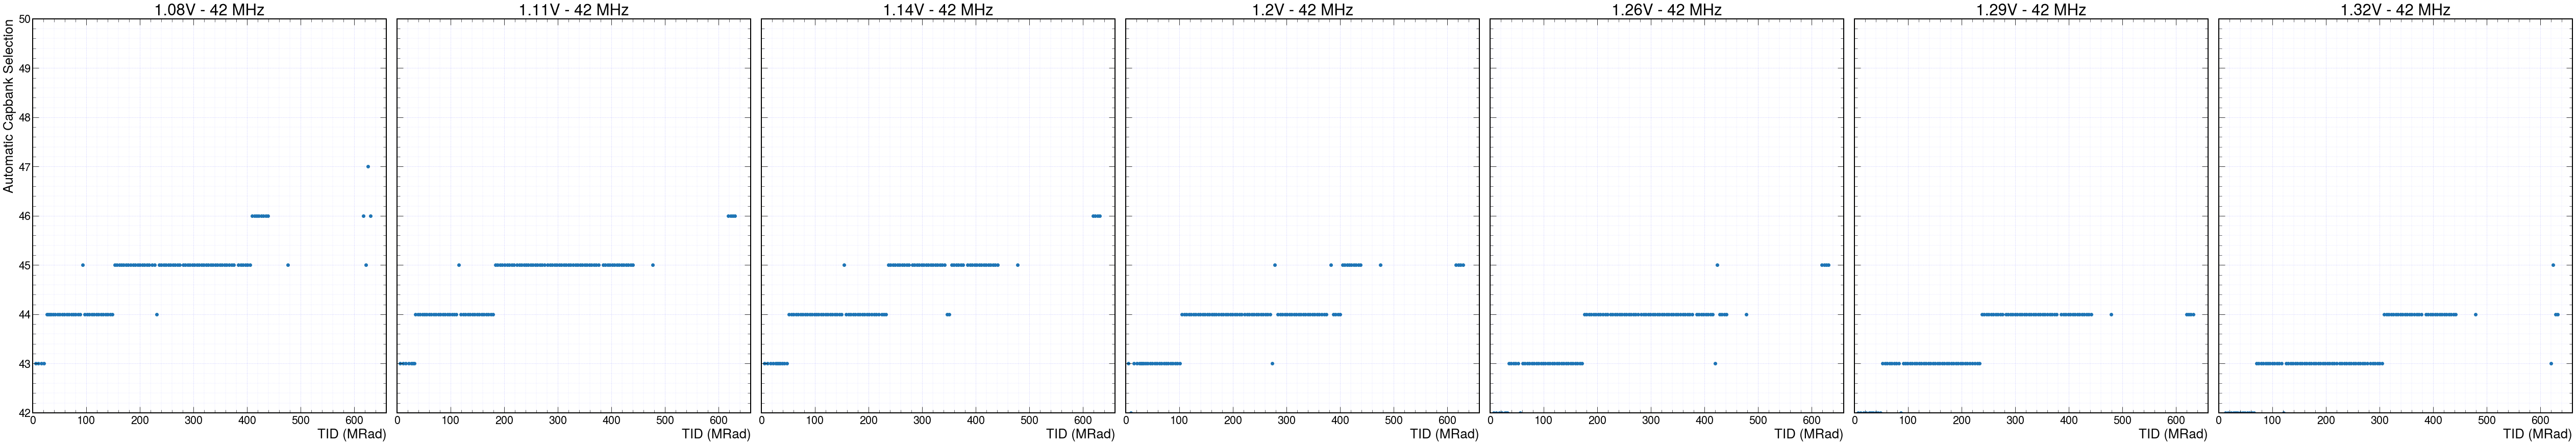

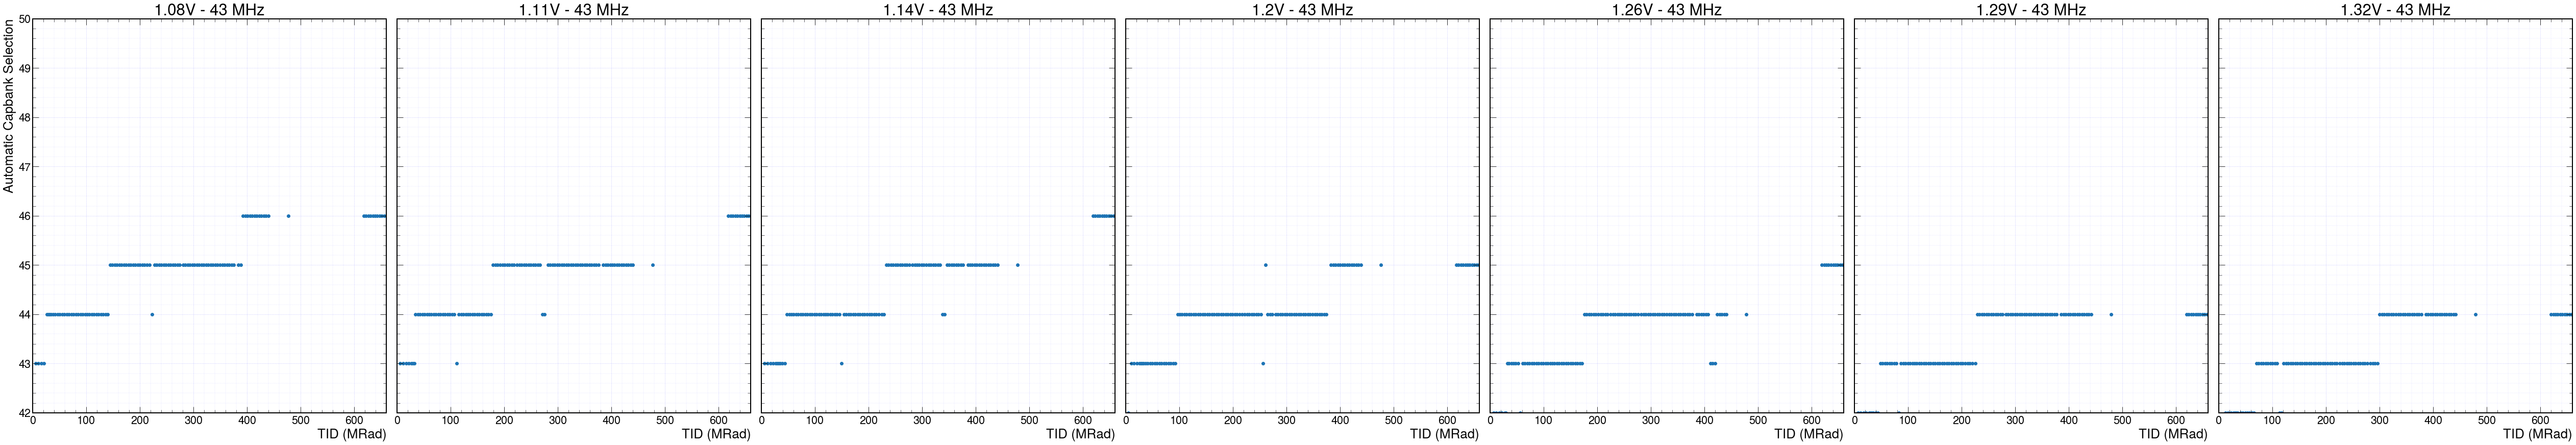

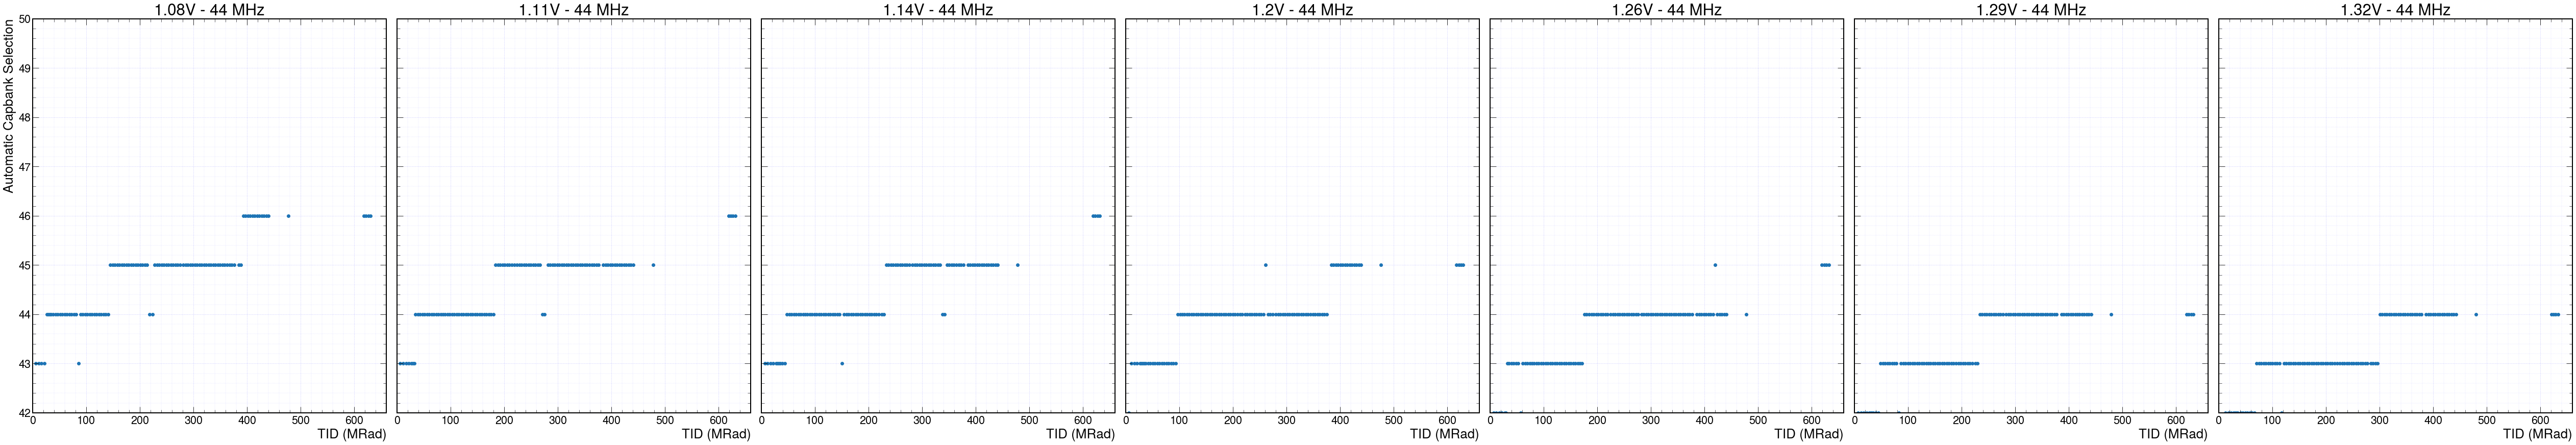

In [63]:
for freq in [42,43,44]:
    cap_bank_value(freq)


# Current vs Time

In [65]:
def current(frequency):
    current = []
    ts = []
    hasl1a = []
    for i in range(len(data)):
        for j in range(len(data[i]['tests'])):
            if "metadata" in data[i]['tests'][j]:
                if "automatic_capbank_setting" in data[i]['tests'][j]['metadata']:
                    if f"-{frequency}]" in data[i]['tests'][j]['nodeid']:
                        current.append(data[i]['tests'][j]['metadata']['Current'])
                        ts.append((data[i]['tests'][j]['metadata']['Timestamp']))
                        hasl1a.append((data[i]['tests'][j]['metadata']['HasL1A']))

    current_1_2 = []
    current_1_08 = []
    current_1_11 = []
    current_1_14 = []
    current_1_26 = []
    current_1_29 = []
    current_1_32 = []
    ts_1_2 = []
    ts_1_08 = []
    ts_1_11 = []
    ts_1_14 = []
    ts_1_26 = []
    ts_1_29 = []
    ts_1_32 = []

    hasl1a_1_2 = []
    hasl1a_1_08 = []
    hasl1a_1_11 = []
    hasl1a_1_14 = []
    hasl1a_1_26 = []
    hasl1a_1_29 = []
    hasl1a_1_32 = []

    for i in range(len(voltages)):
        if voltages[i] >= 1.19 and voltages[i] <= 1.21:
            current_1_2.append(current[i])
            ts_1_2.append(ts[i])
            hasl1a_1_2.append(hasl1a[i])
        elif voltages[i] == 1.08:
            current_1_08.append(current[i])
            ts_1_08.append(ts[i])
            hasl1a_1_08.append(hasl1a[i])
        elif voltages[i] >= 1.10 and voltages[i] <= 1.12:
            current_1_11.append(current[i])
            ts_1_11.append(ts[i])
            hasl1a_1_11.append(hasl1a[i])
        elif voltages[i] >= 1.13 and voltages[i] <= 1.15:
            current_1_14.append(current[i])
            ts_1_14.append(ts[i])
            hasl1a_1_14.append(hasl1a[i])
        elif voltages[i] >= 1.25 and voltages[i] <= 1.27:
            current_1_26.append(current[i])
            ts_1_26.append(ts[i])
            hasl1a_1_26.append(hasl1a[i])
        elif voltages[i] >= 1.28 and voltages[i] <= 1.30:
            current_1_29.append(current[i])
            ts_1_29.append(ts[i])
            hasl1a_1_29.append(hasl1a[i])
        elif voltages[i] >= 1.31 and voltages[i] <= 1.32:
            current_1_32.append(current[i])
            ts_1_32.append(ts[i])
            hasl1a_1_32.append(hasl1a[i])

    current_1_2_tot = []
    ts_1_2_tot = []
    hasl1a_1_2_tot = []
    for i in range (len(current_1_2)):
        for j in range(len(current_1_2[i])):
            current_1_2_tot.append(current_1_2[i][j])
            ts_1_2_tot.append(ts_1_2[i][j])
            hasl1a_1_2_tot.append(hasl1a_1_2[i][j])

    current_1_08_tot = []
    ts_1_08_tot = []
    hasl1a_1_08_tot = []
    for i in range (len(current_1_08)):
        for j in range(len(current_1_08[i])):
            current_1_08_tot.append(current_1_08[i][j])
            ts_1_08_tot.append(ts_1_08[i][j])
            hasl1a_1_08_tot.append(hasl1a_1_08[i][j])
    current_1_11_tot = []
    ts_1_11_tot = []
    hasl1a_1_11_tot = []
    for i in range (len(current_1_11)):
        for j in range(len(current_1_11[i])):
            current_1_11_tot.append(current_1_11[i][j])
            ts_1_11_tot.append(ts_1_11[i][j])
            hasl1a_1_11_tot.append(hasl1a_1_11[i][j])

    current_1_14_tot = []
    ts_1_14_tot = []
    hasl1a_1_14_tot = []
    for i in range (len(current_1_14)):
        for j in range(len(current_1_14[i])):
            current_1_14_tot.append(current_1_14[i][j])
            ts_1_14_tot.append(ts_1_14[i][j])
            hasl1a_1_14_tot.append(hasl1a_1_14[i][j])
    current_1_26_tot = []
    ts_1_26_tot = []
    hasl1a_1_26_tot = []
    for i in range (len(current_1_26)):
        for j in range(len(current_1_26[i])):
            current_1_26_tot.append(current_1_26[i][j])
            ts_1_26_tot.append(ts_1_26[i][j])
            hasl1a_1_26_tot.append(hasl1a_1_26[i][j])
    current_1_29_tot = []
    ts_1_29_tot = []
    hasl1a_1_29_tot = []
    for i in range (len(current_1_29)):
        for j in range(len(current_1_29[i])):
            current_1_29_tot.append(current_1_29[i][j])
            ts_1_29_tot.append(ts_1_29[i][j])
            hasl1a_1_29_tot.append(hasl1a_1_29[i][j])
    current_1_32_tot = []
    ts_1_32_tot = []
    hasl1a_1_32_tot = []
    for i in range (len(current_1_32)):
        for j in range(len(current_1_32[i])):
            current_1_32_tot.append(current_1_32[i][j])
            ts_1_32_tot.append(ts_1_32[i][j])
            hasl1a_1_32_tot.append(hasl1a_1_32[i][j])

    tot_ts_1_2 = []
    tot_ts_1_08 = []
    tot_ts_1_11 = []
    tot_ts_1_14 = []
    tot_ts_1_26 = []
    tot_ts_1_29 = []
    tot_ts_1_32 = []

    for i in range(len(ts_1_2_tot)):
        if current_1_2_tot[i] != -1:
            tot_ts_1_2.append(ts_1_2_tot[i])
            
    for i in range(len(ts_1_08_tot)):
        if current_1_08_tot[i] != -1:
            tot_ts_1_08.append(ts_1_08_tot[i])
            
    for i in range(len(ts_1_11_tot)):
        if current_1_11_tot[i] != -1:
            tot_ts_1_11.append(ts_1_11_tot[i])
            
    for i in range(len(ts_1_14_tot)):
        if current_1_14_tot[i] != -1:
            tot_ts_1_14.append(ts_1_14_tot[i])
            
            
    for i in range(len(ts_1_26_tot)):
        if current_1_26_tot[i] != -1:
            tot_ts_1_26.append(ts_1_26_tot[i])
            
            
    for i in range(len(ts_1_29_tot)):
        if current_1_29_tot[i] != -1:
            tot_ts_1_29.append(ts_1_29_tot[i])
            
    for i in range(len(ts_1_32_tot)):
        if current_1_32_tot[i] != -1:
            tot_ts_1_32.append(ts_1_32_tot[i])

    tot_hasl1a_1_2 = []
    tot_hasl1a_1_08 = []
    tot_hasl1a_1_11 = []
    tot_hasl1a_1_14 = []
    tot_hasl1a_1_26 = []
    tot_hasl1a_1_29 = []
    tot_hasl1a_1_32 = []

    for i in range(len(hasl1a_1_2_tot)):
        if current_1_2_tot[i] != -1:
            tot_hasl1a_1_2.append(hasl1a_1_2_tot[i])
            
    for i in range(len(hasl1a_1_08_tot)):
        if current_1_08_tot[i] != -1:
            tot_hasl1a_1_08.append(hasl1a_1_08_tot[i])
            
    for i in range(len(hasl1a_1_11_tot)):
        if current_1_11_tot[i] != -1:
            tot_hasl1a_1_11.append(hasl1a_1_11_tot[i])
            
    for i in range(len(hasl1a_1_14_tot)):
        if current_1_14_tot[i] != -1:
            tot_hasl1a_1_14.append(hasl1a_1_14_tot[i])
            
            
    for i in range(len(hasl1a_1_26_tot)):
        if current_1_26_tot[i] != -1:
            tot_hasl1a_1_26.append(hasl1a_1_26_tot[i])
            
            
    for i in range(len(hasl1a_1_29_tot)):
        if current_1_29_tot[i] != -1:
            tot_hasl1a_1_29.append(hasl1a_1_29_tot[i])
            
    for i in range(len(hasl1a_1_32_tot)):
        if current_1_32_tot[i] != -1:
            tot_hasl1a_1_32.append(hasl1a_1_32_tot[i])

    tot_hasl1a_1_2 =np.array(tot_hasl1a_1_2)
    tot_hasl1a_1_08 =np.array(tot_hasl1a_1_08)
    tot_hasl1a_1_11 =np.array(tot_hasl1a_1_11)
    tot_hasl1a_1_14 =np.array(tot_hasl1a_1_14)
    tot_hasl1a_1_26 =np.array(tot_hasl1a_1_26)
    tot_hasl1a_1_29 =np.array(tot_hasl1a_1_29)
    tot_hasl1a_1_32 =np.array(tot_hasl1a_1_32)

    tot_ts_1_2 =np.array(tot_ts_1_2)
    tot_ts_1_08 =np.array(tot_ts_1_08)
    tot_ts_1_11 =np.array(tot_ts_1_11)
    tot_ts_1_14 =np.array(tot_ts_1_14)
    tot_ts_1_26 =np.array(tot_ts_1_26)
    tot_ts_1_29 =np.array(tot_ts_1_29)
    tot_ts_1_32 =np.array(tot_ts_1_32)

    hasl1as = [tot_hasl1a_1_08, tot_hasl1a_1_11, tot_hasl1a_1_14, tot_hasl1a_1_2, tot_hasl1a_1_26, tot_hasl1a_1_29, tot_hasl1a_1_32]

    tss = [tot_ts_1_08, tot_ts_1_11, tot_ts_1_14, tot_ts_1_2, tot_ts_1_26, tot_ts_1_29, tot_ts_1_32]
                    
    megarad_dose = []
    for i in range(7):
        tss[i] = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f") for x in tss[i] ]
        delTimes = [x - goodTimes[0] for x in tss[i]]
        delTimes = np.array(delTimes)
        delTimes = delTimes/timedelta(minutes=1)
        rad_dose = 9.2/60
        megarad_dose.append(rad_dose*delTimes)

    current_1_2_tot = [x for x in current_1_2_tot if x != -1]
    current_1_08_tot = [x for x in current_1_08_tot if x != -1]
    current_1_11_tot = [x for x in current_1_11_tot if x != -1]
    current_1_14_tot = [x for x in current_1_14_tot if x != -1]
    current_1_26_tot = [x for x in current_1_26_tot if x != -1]
    current_1_29_tot = [x for x in current_1_29_tot if x != -1]
    current_1_32_tot = [x for x in current_1_32_tot if x != -1]

    current_1_2_tot = np.array(current_1_2_tot)
    current_1_08_tot = np.array(current_1_08_tot)
    current_1_11_tot = np.array(current_1_11_tot)
    current_1_14_tot = np.array(current_1_14_tot)
    current_1_26_tot = np.array(current_1_26_tot)
    current_1_29_tot = np.array(current_1_29_tot)
    current_1_32_tot = np.array(current_1_32_tot)

    currents = [current_1_08_tot,current_1_11_tot,current_1_14_tot,current_1_2_tot,current_1_26_tot,current_1_29_tot,
            current_1_32_tot]

    fig,axs=plt.subplots(figsize=(70,12),ncols=7,nrows=1, layout="constrained")

    keylist = [1.08,1.11,1.14,1.20,1.26,1.29,1.32]
    for i in range(len(keylist)):
        axs[i].scatter(megarad_dose[i][hasl1as[i]==1], currents[i][hasl1as[i]==1], label="Has L1A")
        axs[i].scatter(megarad_dose[i][hasl1as[i]==0], currents[i][hasl1as[i]==0], label = "No L1A")
        axs[i].set_title(f"{keylist[i]}V - {frequency} MHz")
        axs[i].set_ylabel('Current (A)')
        axs[i].set_xlabel('TID (MRad)')
        axs[i].set_ylim(0.15,0.31)
        axs[i].set_xlim(0,660)

            
    for ax in axs.flat:
        ax.label_outer()   
    fig.savefig(f'./current_measurement_results_{frequency}.jpg')  

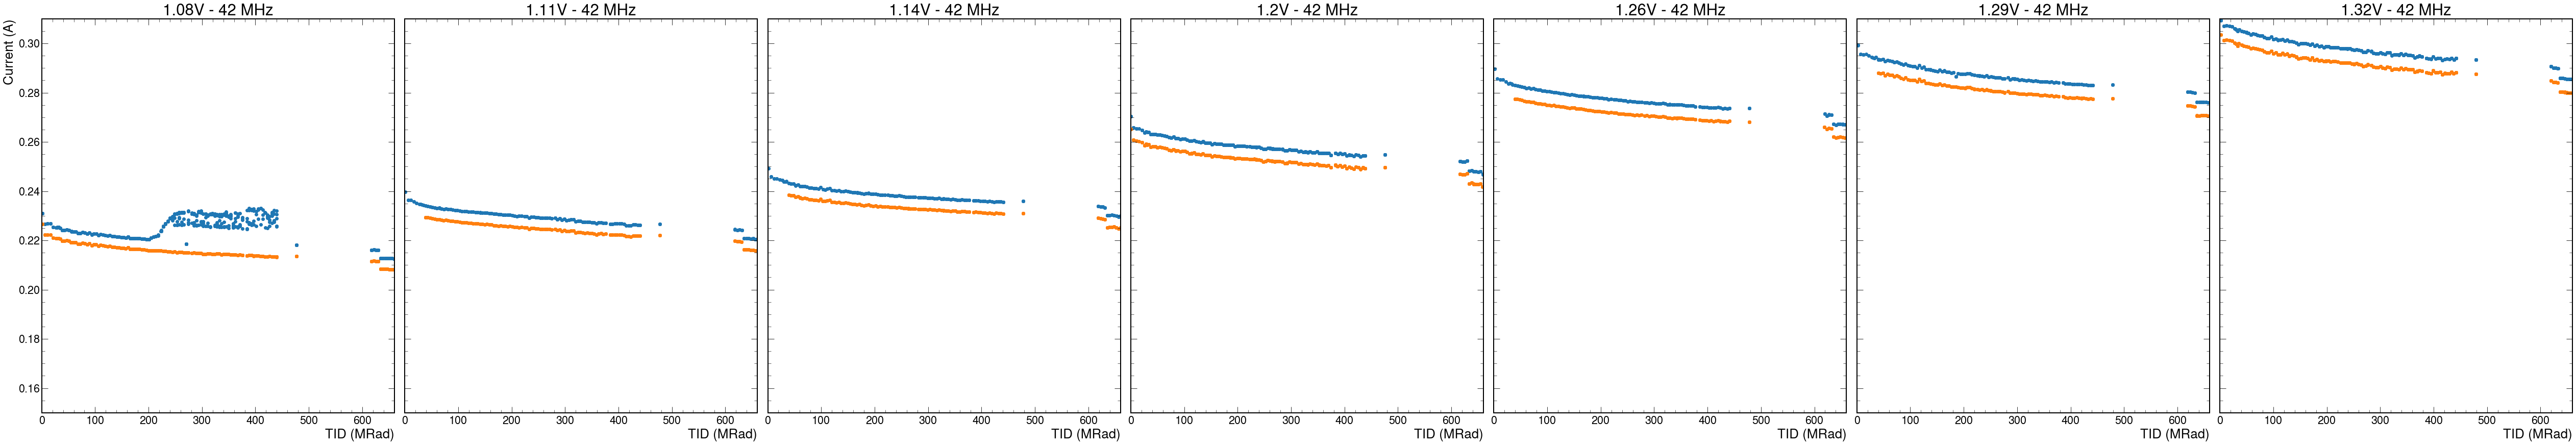

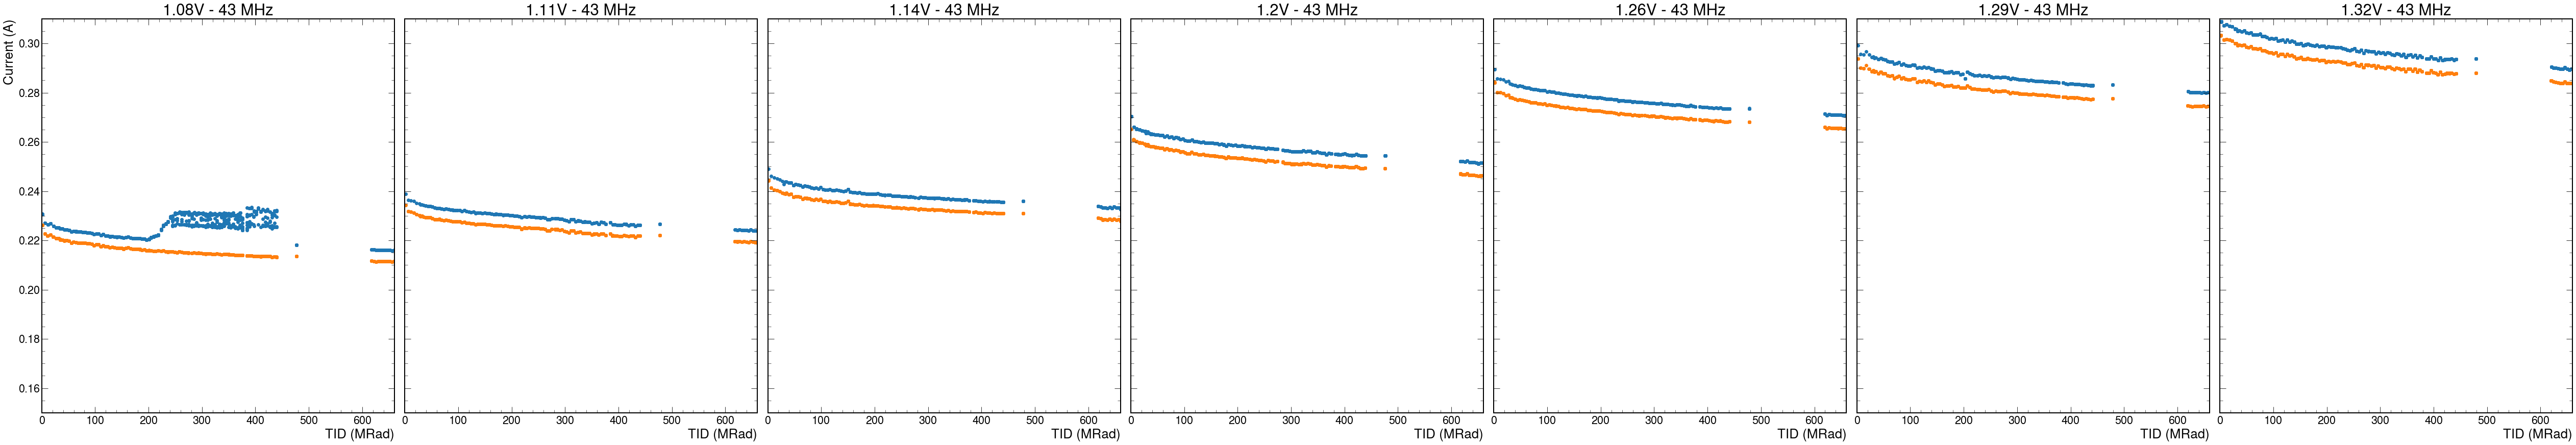

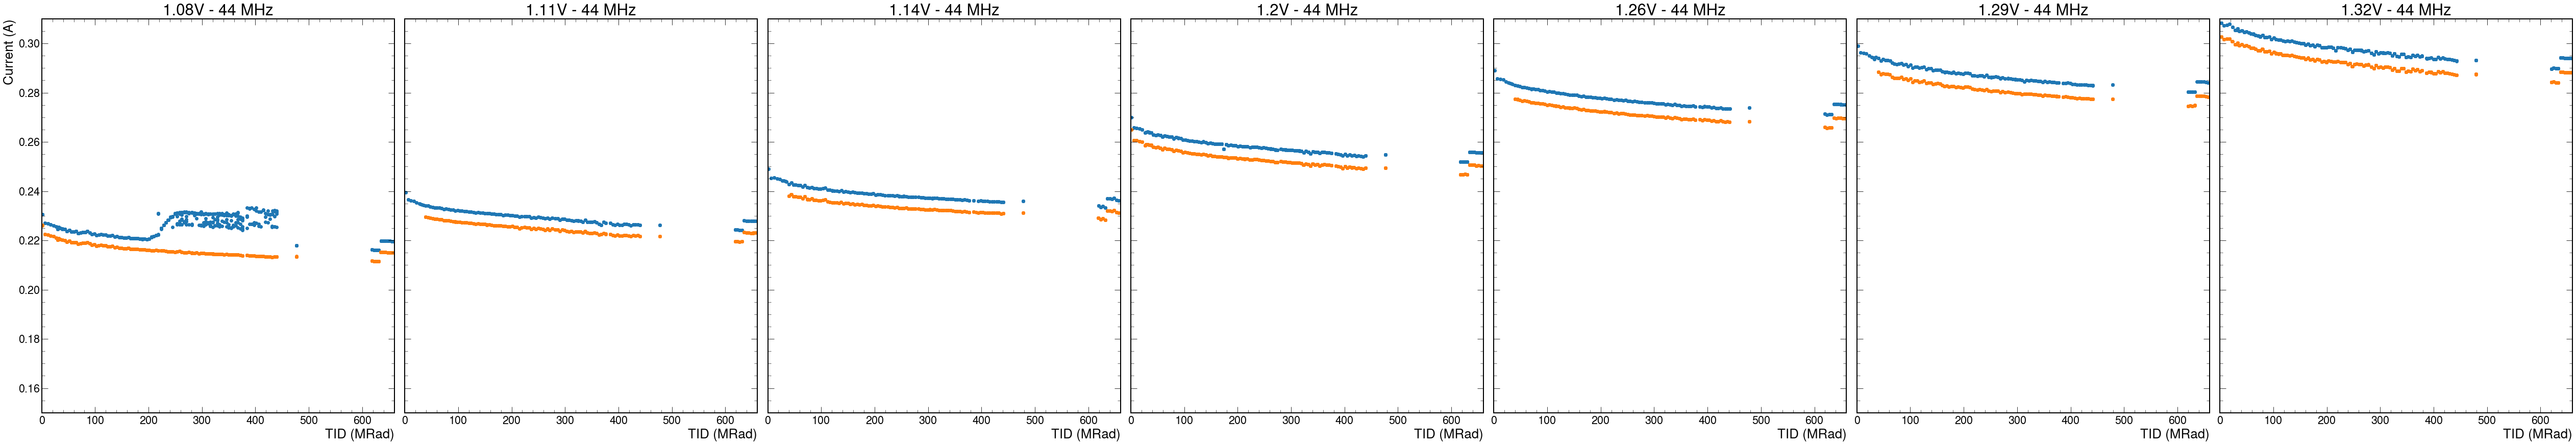

In [66]:
for freq in [42,43,44]:
    current(freq)

# Delay Scan Plots

In [22]:
errcount_42 = []
bitcount_42 = []
etx_v_42 = []

errcount_43 = []
bitcount_43 = []
etx_v_43 = []

errcount_44 = []
bitcount_44 = []
etx_v_44 = []
has_var_freq = np.zeros(len(data))
for i in range(len(data)):
    for j in range(len(data[i]['tests'])):
            if "metadata" in data[i]['tests'][j]:
                if 'eTX_delays' in data[i]['tests'][j]['metadata']:
                    if "-42]" in data[i]['tests'][j]['nodeid']:
                        bitcount_42.append(data[i]['tests'][j]['metadata']['eTX_bitcounts'])
                        errcount_42.append((data[i]['tests'][j]['metadata']['eTX_errcounts']))
                        etx_v_42.append((data[i]['tests'][j]['metadata']['voltage']))
                        has_var_freq[i] = 1
                    elif "-43]" in data[i]['tests'][j]['nodeid']:
                        bitcount_43.append(data[i]['tests'][j]['metadata']['eTX_bitcounts'])
                        errcount_43.append((data[i]['tests'][j]['metadata']['eTX_errcounts']))
                        etx_v_43.append((data[i]['tests'][j]['metadata']['voltage']))
                    elif "-44]" in data[i]['tests'][j]['nodeid']:
                        bitcount_44.append(data[i]['tests'][j]['metadata']['eTX_bitcounts'])
                        errcount_44.append((data[i]['tests'][j]['metadata']['eTX_errcounts']))
                        etx_v_44.append((data[i]['tests'][j]['metadata']['voltage']))
                    else:
                        bitcount_43.append(data[i]['tests'][j]['metadata']['eTX_bitcounts'])
                        errcount_43.append((data[i]['tests'][j]['metadata']['eTX_errcounts']))
                        etx_v_43.append((data[i]['tests'][j]['metadata']['voltage']))
has_var_freq1 = np.array(list(has_var_freq)+[1])

In [23]:
norm_errs_42 = (np.array(errcount_42))/(np.array(bitcount_42))
norm_errs_43 = (np.array(errcount_43))/(np.array(bitcount_43))
norm_errs_44 = (np.array(errcount_44))/(np.array(bitcount_44))

/var/folders/pj/jdsydbt93y3fty8bxll08bd00000gn/T/ipykernel_4539/3310304277.py:2: RuntimeWarning: invalid value encountered in true_divide
  norm_errs_43 = (np.array(errcount_43))/(np.array(bitcount_43))


In [24]:
norm_errs_results_42 = dict.fromkeys(list(np.unique(np.array(etx_v_42))))
norm_errs_results_43 = dict.fromkeys(list(np.unique(np.array(etx_v_43))))
norm_errs_results_44 = dict.fromkeys(list(np.unique(np.array(etx_v_44))))

for key in norm_errs_results_42.keys():
    norm_errs_results_42[key] = np.array([norm_errs_42[i] for i in range(len(etx_v_42)) if etx_v_42[i]==key])
for key in norm_errs_results_43.keys():
    norm_errs_results_43[key] = np.array([norm_errs_43[i] for i in range(len(etx_v_43)) if etx_v_43[i]==key])
for key in norm_errs_results_44.keys():
    norm_errs_results_44[key] = np.array([norm_errs_44[i] for i in range(len(etx_v_44)) if etx_v_44[i]==key])


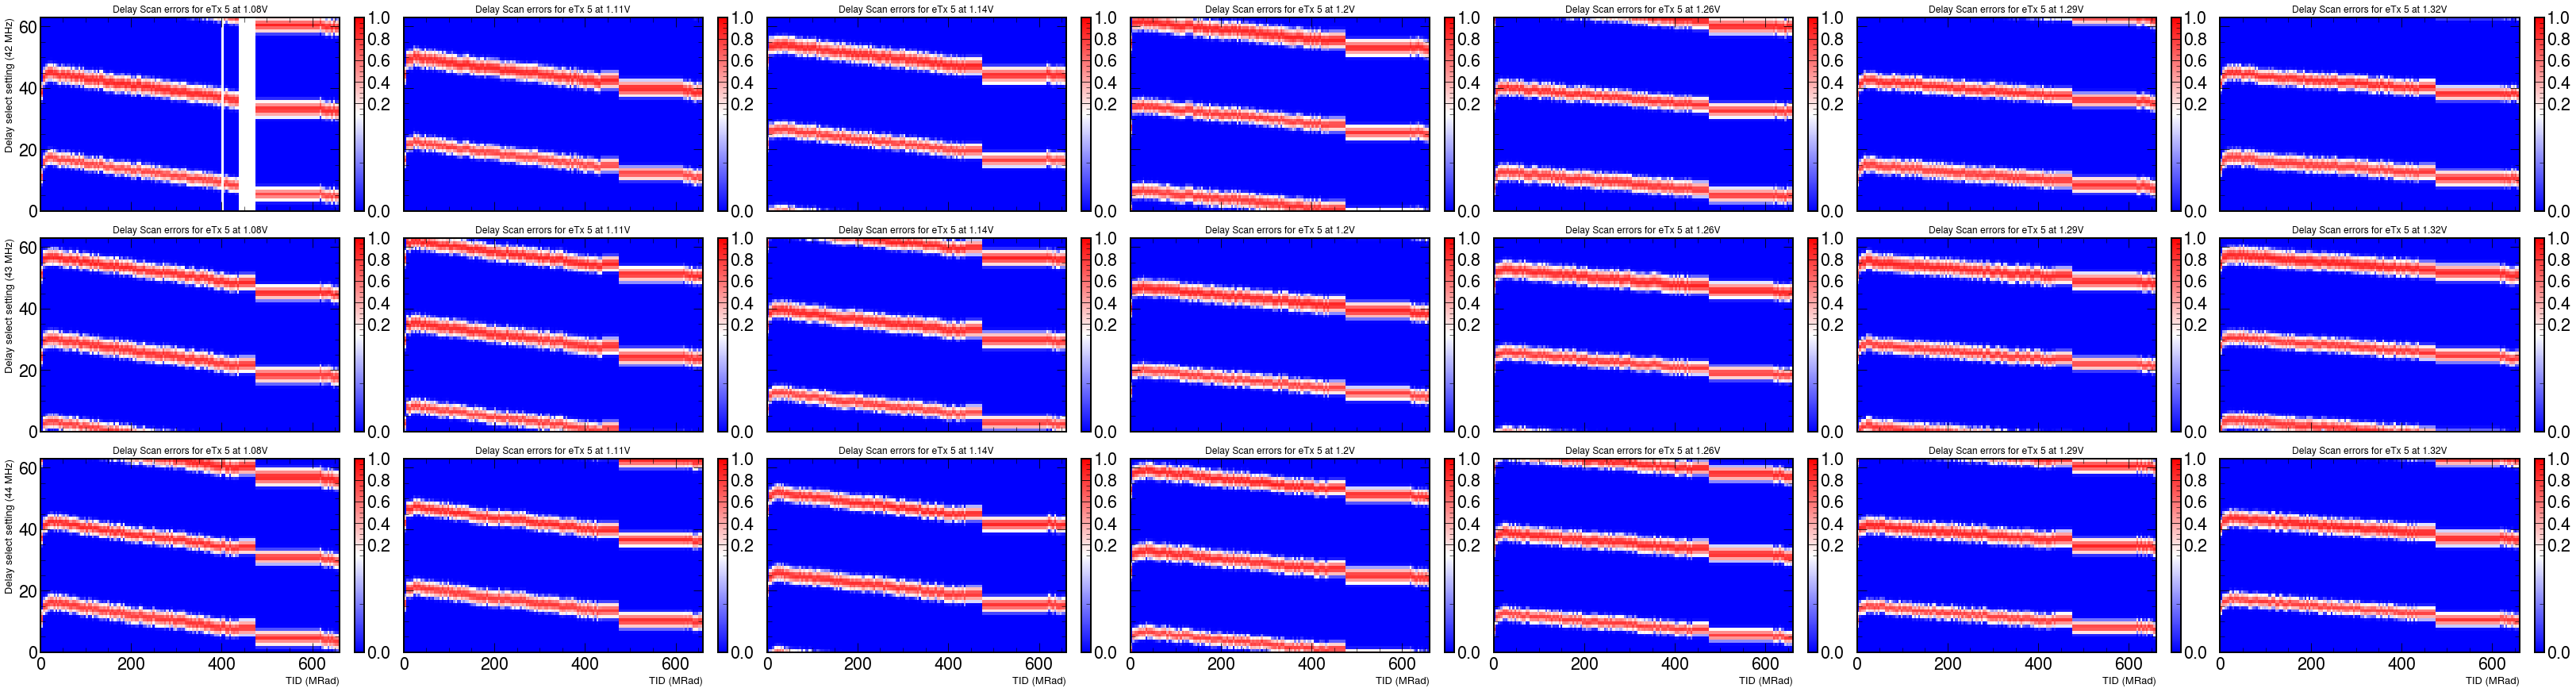

In [163]:
fig,axs=plt.subplots(figsize=(45,12),ncols=7,nrows=3, layout="constrained")
keylist = [1.08,1.11,1.14,1.20,1.26,1.29,1.32]
norm = mcolors.TwoSlopeNorm(vmin=0, vmax = 1, vcenter=.1)
for j in range(len(keylist)):
    for i in range(3):
        if i == 0:
            nTrials = len(norm_errs_results_42[keylist[j]])
            a,b=np.meshgrid(megarad_dose,np.arange(63))
            rand = nTrials + 1
            chData = norm_errs_results_42[keylist[j]][:,5,:]
            h = axs[i,j].hist2d(a.flatten(),b.flatten(),weights=chData.T.flatten(),bins=(megarad_dose_plots,np.arange(64)),cmap='bwr',norm=norm)
            axs[i,j].set_title(f"Delay Scan errors for eTx 5 at {keylist[j]}V", size=12)
            axs[i,j].set_ylabel('Delay select setting (42 MHz)', size=13)
            axs[i,j].set_xlabel('TID (MRad)', size=13)
            axs[i,j].set_xlim(0,660)
            cb=fig.colorbar(h[3], ax = axs[i,j])
            
      
            
        if i == 1:
            nTrials = len(norm_errs_results_43[keylist[j]])
            a,b=np.meshgrid(megarad_dose,np.arange(63))
            rand = nTrials + 1
            chData = norm_errs_results_43[keylist[j]][:,5,:]
            h = axs[i,j].hist2d(a.flatten(),b.flatten(),weights=chData.T.flatten(),bins=(megarad_dose_plots,np.arange(64)),cmap='bwr',norm=norm)
            #plt.colorbar().set_label(label='Transmission errors',size=11)
            axs[i,j].set_title(f"Delay Scan errors for eTx 5 at {keylist[j]}V", size=12)
            axs[i,j].set_ylabel('Delay select setting (43 MHz)', size=13)
            axs[i,j].set_xlabel('TID (MRad)', size=13)
            axs[i,j].set_xlim(0,660)
            cb=fig.colorbar(h[3], ax = axs[i,j])
        if i == 2:
            nTrials = len(norm_errs_results_44[keylist[j]])
            a,b=np.meshgrid(megarad_dose,np.arange(63))
            rand = nTrials + 1
            chData = norm_errs_results_44[keylist[j]][:,5,:]
            h = axs[i,j].hist2d(a.flatten(),b.flatten(),weights=chData.T.flatten(),bins=(megarad_dose_plots,np.arange(64)),cmap='bwr',norm=norm)
            #plt.colorbar().set_label(label='Transmission errors',size=11)
            axs[i,j].set_title(f"Delay Scan errors for eTx 5 at {keylist[j]}V", size=12)
            axs[i,j].set_ylabel('Delay select setting (44 MHz)', size=13)
            axs[i,j].set_xlabel('TID (MRad)', size=13)
            axs[i,j].set_xlim(0,660)
            cb=fig.colorbar(h[3], ax = axs[i,j])
for ax in axs.flat:
    ax.label_outer()
fig.savefig("./delay_scan_results.jpg")

ValueError: The weights and list don't have the same length.

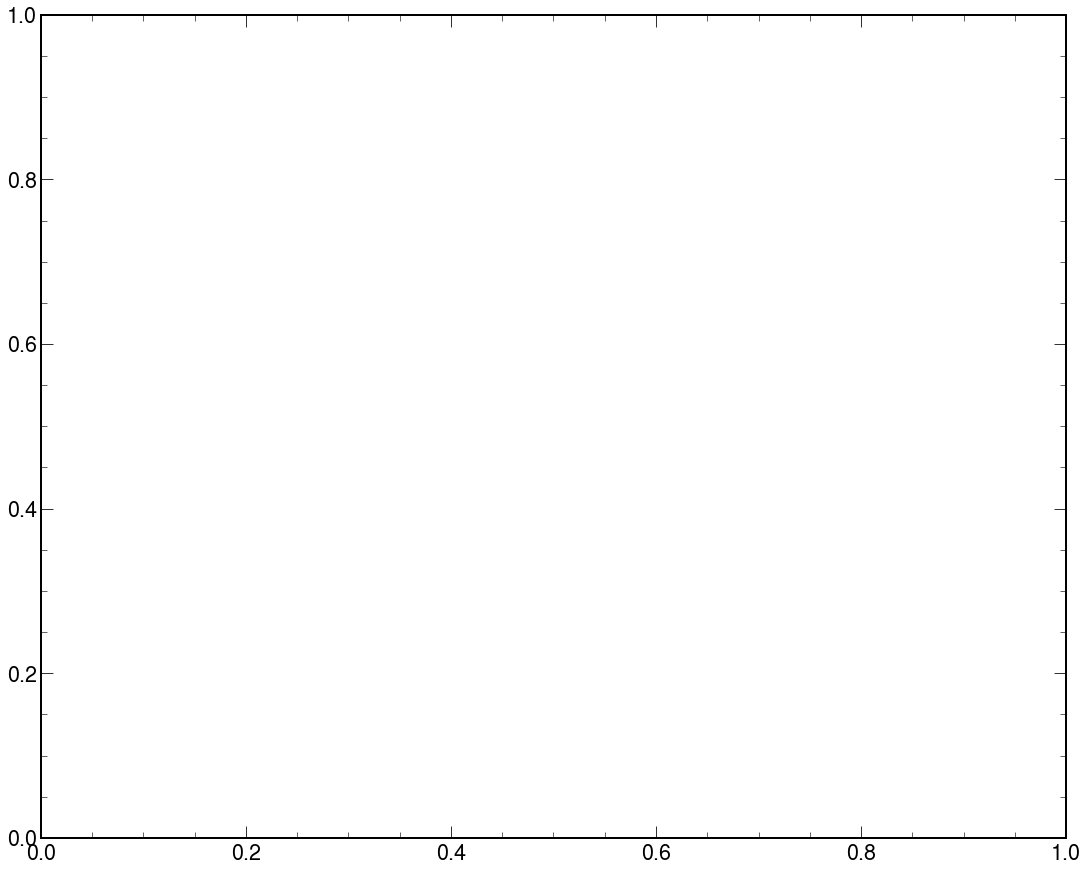

In [26]:
fig,axs=plt.subplots(figsize=(15,12), layout="constrained")
keylist = [1.08,1.11,1.14,1.20,1.26,1.29,1.32]
norm = mcolors.TwoSlopeNorm(vmin=0, vmax = 1, vcenter=.1)

nTrials = len(norm_errs_results_43[1.08])
a,b=np.meshgrid(megarad_dose,np.arange(63))
rand = nTrials + 1
chData = norm_errs_results_43[1.08][:,5,:]
h = axs.hist2d(a.flatten(),b.flatten(),weights=chData.T.flatten(),bins=(megarad_dose_plots,np.arange(64)),cmap='bwr',norm=norm)
#plt.colorbar().set_label(label='Transmission errors',size=11)
axs.set_title(f"Delay Scan errors for eTx 5 at 1.08V Chip 9")
axs.set_ylabel('Delay select setting')
axs.set_xlabel('TID (MRad)')
axs.set_xlim(0,660)
cb=fig.colorbar(h[3], ax = axs)
fig.savefig("./delay_scan_presentation_chip9.jpg")

ValueError: The weights and list don't have the same length.

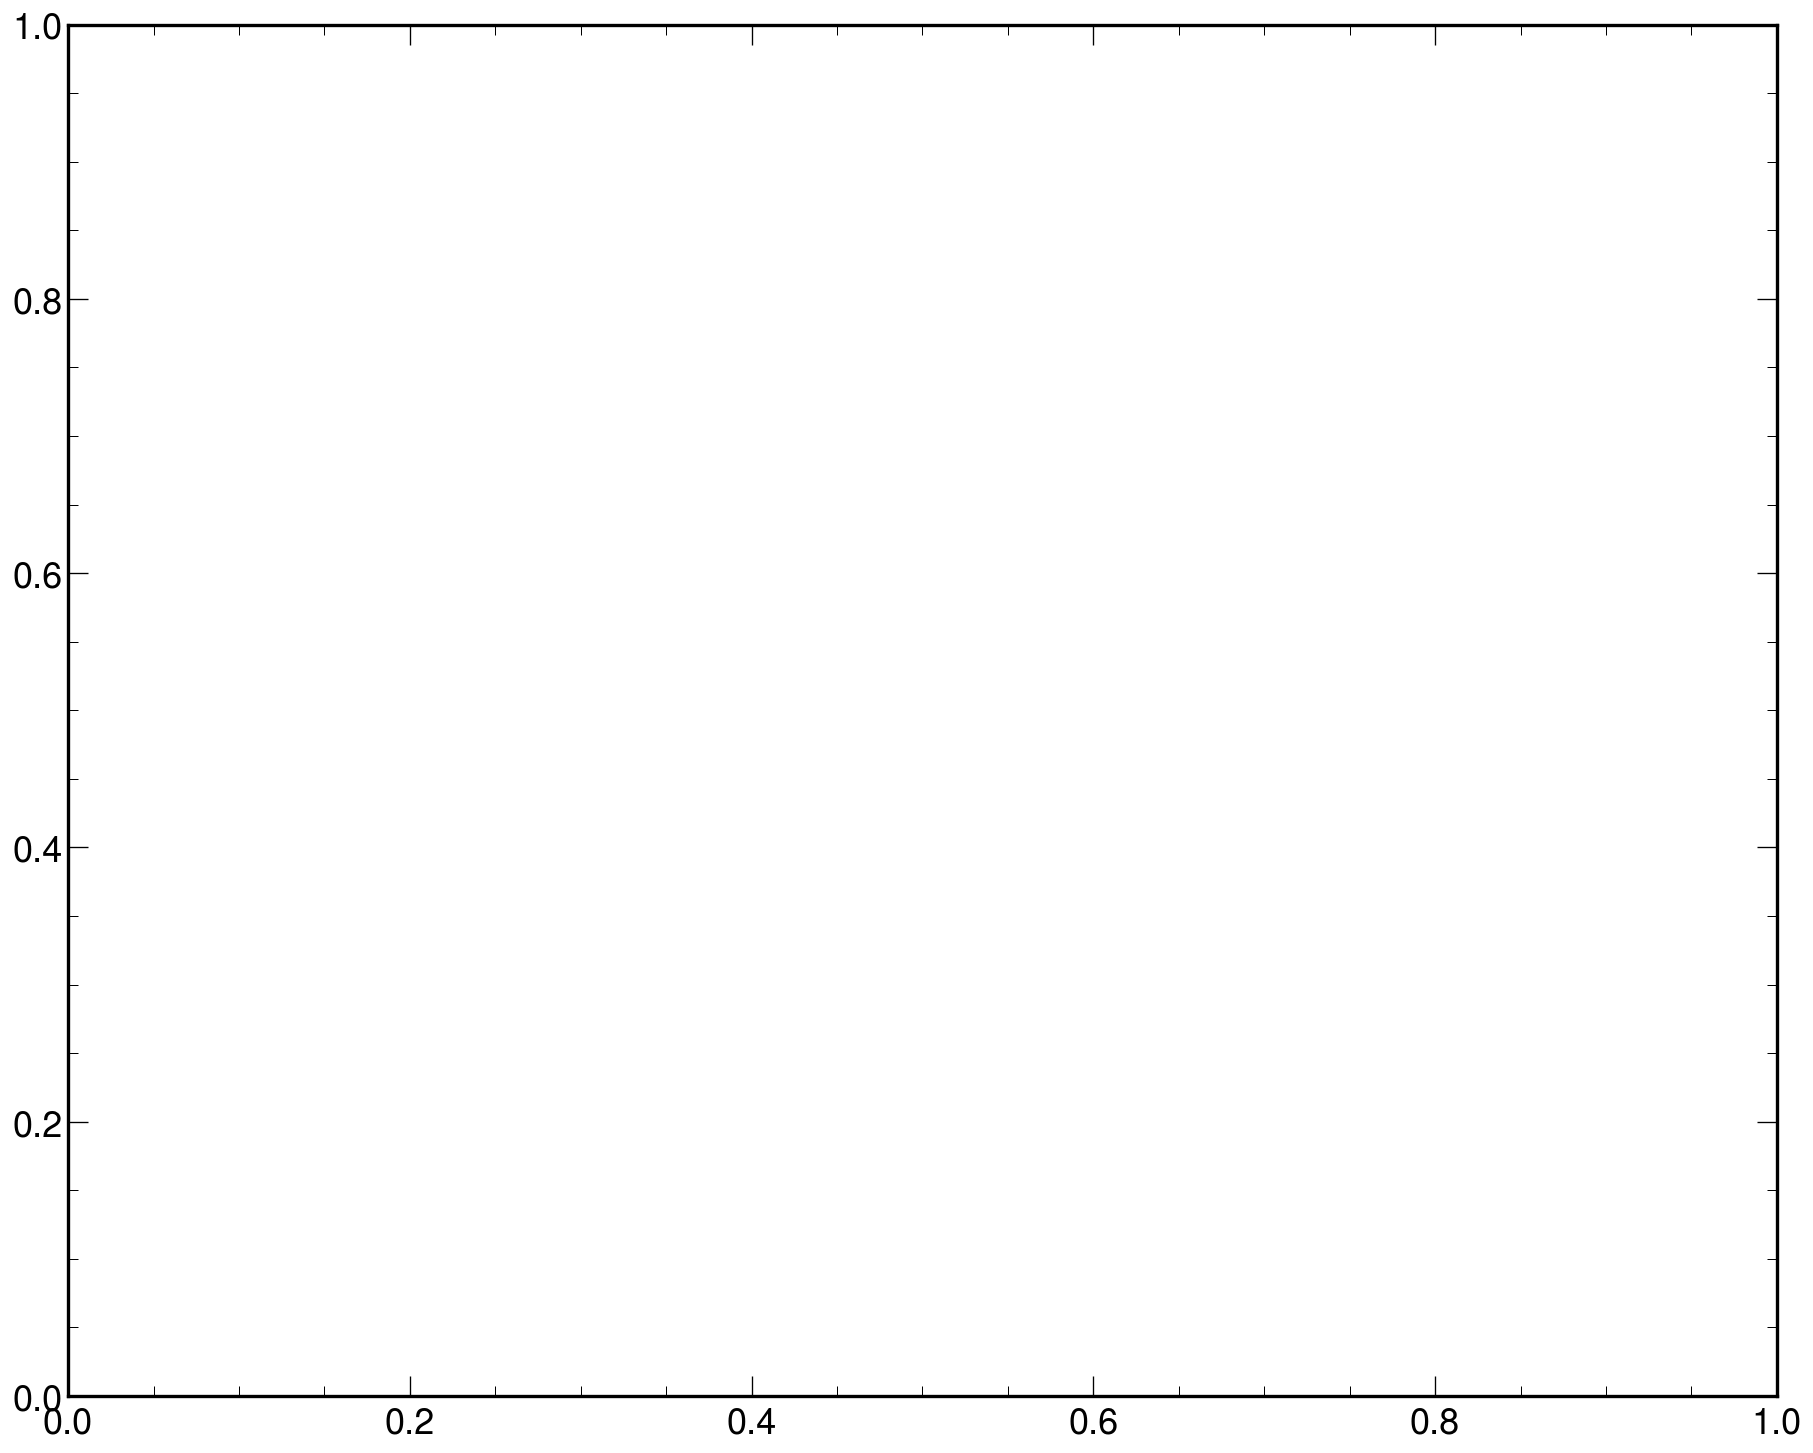

In [27]:
fig,axs=plt.subplots(figsize=(15,12), dpi=120, layout="constrained")
keylist = [1.08,1.11,1.14,1.20,1.26,1.29,1.32]
norm = mcolors.TwoSlopeNorm(vmin=0, vmax = 255, vcenter = 0.99)
nTrials = len(norm_errs_results_43[1.20])
a,b=np.meshgrid(megarad_dose,np.arange(63))
rand = nTrials + 1
chData = norm_errs_results_43[1.20][:,5,:]
h =axs.hist2d(a.flatten(),b.flatten(),weights=chData.T.flatten(),bins=(megarad_dose_plots,np.arange(64)),cmap=jsw_cmap)
#plt.colorbar().set_label(label='Transmission errors',size=11)
axs.set_title(f"Phase Scan errors for eRx 11 at 1.2V Chip 7F")
axs.set_ylabel('Phase delay setting')
axs.set_xlabel('TID (MRad)')
axs.set_xlim(0,660)
cb=fig.colorbar(h[3], ax = axs,label='PRBS error count in ~1 ms')
cb._set_scale(matplotlib.scale.FuncScale(cb._long_axis(), (forward, inverse)))
cb.set_ticks([0, 1, 32, 64, 96, 128, 160, 192, 224, 255])
cb.set_ticks([], minor=True)
axs.legend(loc='upper left', framealpha=1, title='ECON-D-P1')

fig.savefig("/Users/alexcampbell/Documents/Research/Fermilab/PLLLockingrange/plots/delay_scan_presentation_chip7.pdf", format="pdf", bbox_inches="tight")

In [73]:
len(megarad_dose)

116

# Phase Scan

In [13]:
norm_errs_42 = []
norm_errs_43 = []
norm_errs_44 = []

erx_v_42 = []
erx_v_43 = []
erx_v_44 = []
has_var_freq = np.zeros(len(data))
for i in range(len(data)):
    for j in range(len(data[i]['tests'])):
        if "metadata" in data[i]['tests'][j]:
            if 'eRX_errcounts' in data[i]['tests'][j]['metadata']:
                if "-39]" in data[i]['tests'][j]['nodeid']:
                    norm_errs_42.append((data[i]['tests'][j]['metadata']['eRX_errcounts']))
                    erx_v_42.append((data[i]['tests'][j]['metadata']['voltage']))
                    has_var_freq[i] = 1
                elif "-40]" in data[i]['tests'][j]['nodeid']:
                    norm_errs_43.append((data[i]['tests'][j]['metadata']['eRX_errcounts']))
                    erx_v_43.append((data[i]['tests'][j]['metadata']['voltage']))
                elif "-41]" in data[i]['tests'][j]['nodeid']:
                    norm_errs_44.append((data[i]['tests'][j]['metadata']['eRX_errcounts']))
                    erx_v_44.append((data[i]['tests'][j]['metadata']['voltage']))
                else:
                    norm_errs_43.append((data[i]['tests'][j]['metadata']['eRX_errcounts']))
                    erx_v_43.append((data[i]['tests'][j]['metadata']['voltage']))
has_var_freq1 = np.array(list(has_var_freq)+[1])

In [14]:
norm_errs_results_42 = dict.fromkeys(list(np.unique(np.array(erx_v_42))))
norm_errs_results_43 = dict.fromkeys(list(np.unique(np.array(erx_v_43))))
norm_errs_results_44 = dict.fromkeys(list(np.unique(np.array(erx_v_44))))

for key in norm_errs_results_42.keys():
    norm_errs_results_42[key] = np.array([norm_errs_42[i] for i in range(len(erx_v_42)) if erx_v_42[i]==key])
for key in norm_errs_results_43.keys():
    norm_errs_results_43[key] = np.array([norm_errs_43[i] for i in range(len(erx_v_43)) if erx_v_43[i]==key])
for key in norm_errs_results_44.keys():
    norm_errs_results_44[key] = np.array([norm_errs_44[i] for i in range(len(erx_v_44)) if erx_v_44[i]==key])

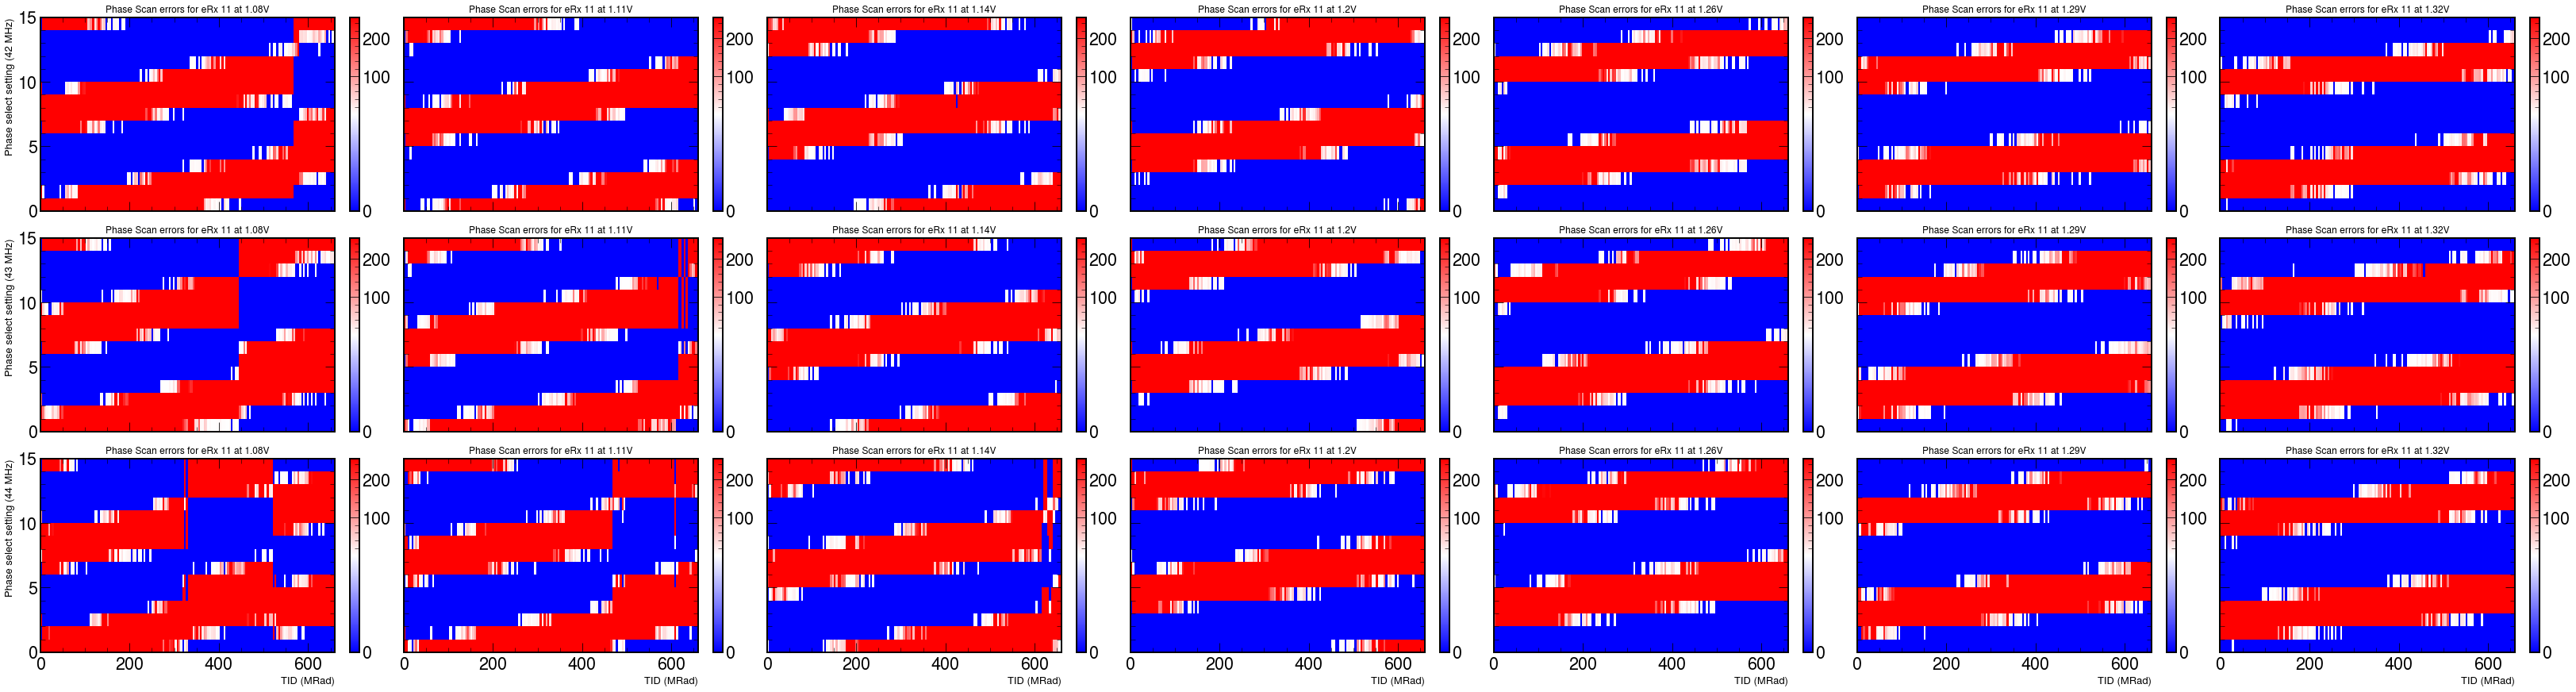

In [15]:
fig,axs=plt.subplots(figsize=(45,12),ncols=7,nrows=3, layout="constrained")
keylist = [1.08,1.11,1.14,1.20,1.26,1.29,1.32]
norm = mcolors.TwoSlopeNorm(vmin=0, vmax = 255, vcenter=.9)
for j in range(len(keylist)):
    for i in range(3):
        if i == 0:
            nTrials = len(norm_errs_results_42[keylist[j]])
            a,b=np.meshgrid(megarad_dose,np.arange(15))
            rand = nTrials + 1
            chData = norm_errs_results_42[keylist[j]][:,:,11]
            h =axs[i,j].hist2d(a.flatten(),b.flatten(),weights=chData.T.flatten(),bins=(megarad_dose_plots,np.arange(16)),cmap='bwr',norm=norm)
            #plt.colorbar().set_label(label='Transmission errors',size=11)
            axs[i,j].set_title(f"Phase Scan errors for eRx 11 at {keylist[j]}V", size=12)
            axs[i,j].set_ylabel('Phase select setting (42 MHz)', size=13)
            axs[i,j].set_xlabel('Run number', size=13)
            axs[i,j].set_xlabel('TID (MRad)', size=13)
            axs[i,j].set_xlim(0,660)
            cb=fig.colorbar(h[3], ax = axs[i,j])
            
        if i == 1:
            nTrials = len(norm_errs_results_43[keylist[j]])
            a,b=np.meshgrid(megarad_dose,np.arange(15))
            rand = nTrials + 1
            chData = norm_errs_results_43[keylist[j]][:,:,11]
            h =axs[i,j].hist2d(a.flatten(),b.flatten(),weights=chData.T.flatten(),bins=(megarad_dose_plots,np.arange(16)),cmap='bwr',norm=norm)
            #plt.colorbar().set_label(label='Transmission errors',size=11)
            axs[i,j].set_title(f"Phase Scan errors for eRx 11 at {keylist[j]}V", size=12)
            axs[i,j].set_ylabel('Phase select setting (43 MHz)', size=13)
            axs[i,j].set_xlabel('Run number', size=13)
            axs[i,j].set_xlabel('TID (MRad)', size=13)
            axs[i,j].set_xlim(0,660)
            cb=fig.colorbar(h[3], ax = axs[i,j])
        if i == 2:
            nTrials = len(norm_errs_results_44[keylist[j]])
            a,b=np.meshgrid(megarad_dose,np.arange(15))
            rand = nTrials + 1
            chData = norm_errs_results_44[keylist[j]][:,:,11]
            h=axs[i,j].hist2d(a.flatten(),b.flatten(),weights=chData.T.flatten(),bins=(megarad_dose_plots,np.arange(16)),cmap='bwr',norm=norm)
            #plt.colorbar().set_label(label='Transmission errors',size=11)
            axs[i,j].set_title(f"Phase Scan errors for eRx 11 at {keylist[j]}V", size=12)
            axs[i,j].set_ylabel('Phase select setting (44 MHz)', size=13)
            axs[i,j].set_xlabel('Run number', size=13)
            axs[i,j].set_xlabel('TID (MRad)', size=13)
            axs[i,j].set_xlim(0,660)
            cb=fig.colorbar(h[3], ax = axs[i,j])
for ax in axs.flat:
    ax.label_outer()
fig.savefig("./phase_scan_results.jpg")

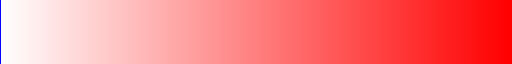

In [11]:
Cut = 1e-3
jsw_cmap = mcolors.LinearSegmentedColormap('blue_to_red', {'red': [(0.0, 0.0, 0.0),
                                                                  (Cut/255, 0.0, 1.0),
                                                                  (255.0/255, 1.0, 1.0)],
                                                          'green': [(0.0, 0.0, 0.0),
                                                                    (Cut/255, 0.0, 1.0),
                                                                    (255.0/255, 0.0, 0.0)],
                                                          'blue': [(0.0, 1.0, 1.0),
                                                                   (Cut/255, 1.0, 1.0),
                                                                   (255.0/255, 0.0, 0.0)]}, N=256*10)
jsw_cmap

In [13]:
z = 0.07
q = 0.15
# x goes from 0 to 255, inclusive
# From 0 to q, we should go from 0 to z
# From q to 255, we should go from z to 1
def forward(x):
    return ((z * (x/q)) * (x < q)) + (((1-z) * (x-q) / (255-q) + z) * (x >= q))
    
# y goes from 0 to 1, inclusive
# From 0 to z, we should go from 0 to 1
# From z to 1, we should go from 1 to 255
def inverse(y):
    return ((((q)*y/z - q)) * (y < z)) + (((y-z) / (1 - z) * (255-q) + q) * (y >= z))

In [ ]:
counts = array([J["tests"][k]["metadata"]["eRX_errcounts"] for k in range(len(J['tests'])) if J["tests"][k]["nodeid"] == "test_TID.py::test_ePortRXPRBS[1.2]"][0])

fig, ax = subplots(nrows=1, ncols=1, figsize=(6*1, 6*1), dpi=120)
sca(ax)
pcm = pcolormesh(arange(13)-0.5, arange(16)-0.5, 
                 counts,
                 cmap=jsw_cmap, 
                 vmin=0, vmax=255, linewidth=0)
pcm.set_edgecolor('face')
cb = colorbar(label='PRBS error count in ~1 ms')
cb._set_scale(matplotlib.scale.FuncScale(cb._long_axis(), (forward, inverse)))
cb.set_ticks([0, 1, 32, 64, 96, 128, 160, 192, 224, 255])
cb.set_ticks([], minor=True)
legend(loc='upper left', framealpha=1, title='ECON-D-P1')
xticks(arange(12))
xlabel('1.28 GHz eRx')
yticks(arange(15))
ylabel(f'Phase delay setting')
tight_layout()
savefig('plots/phase_scan_econd.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


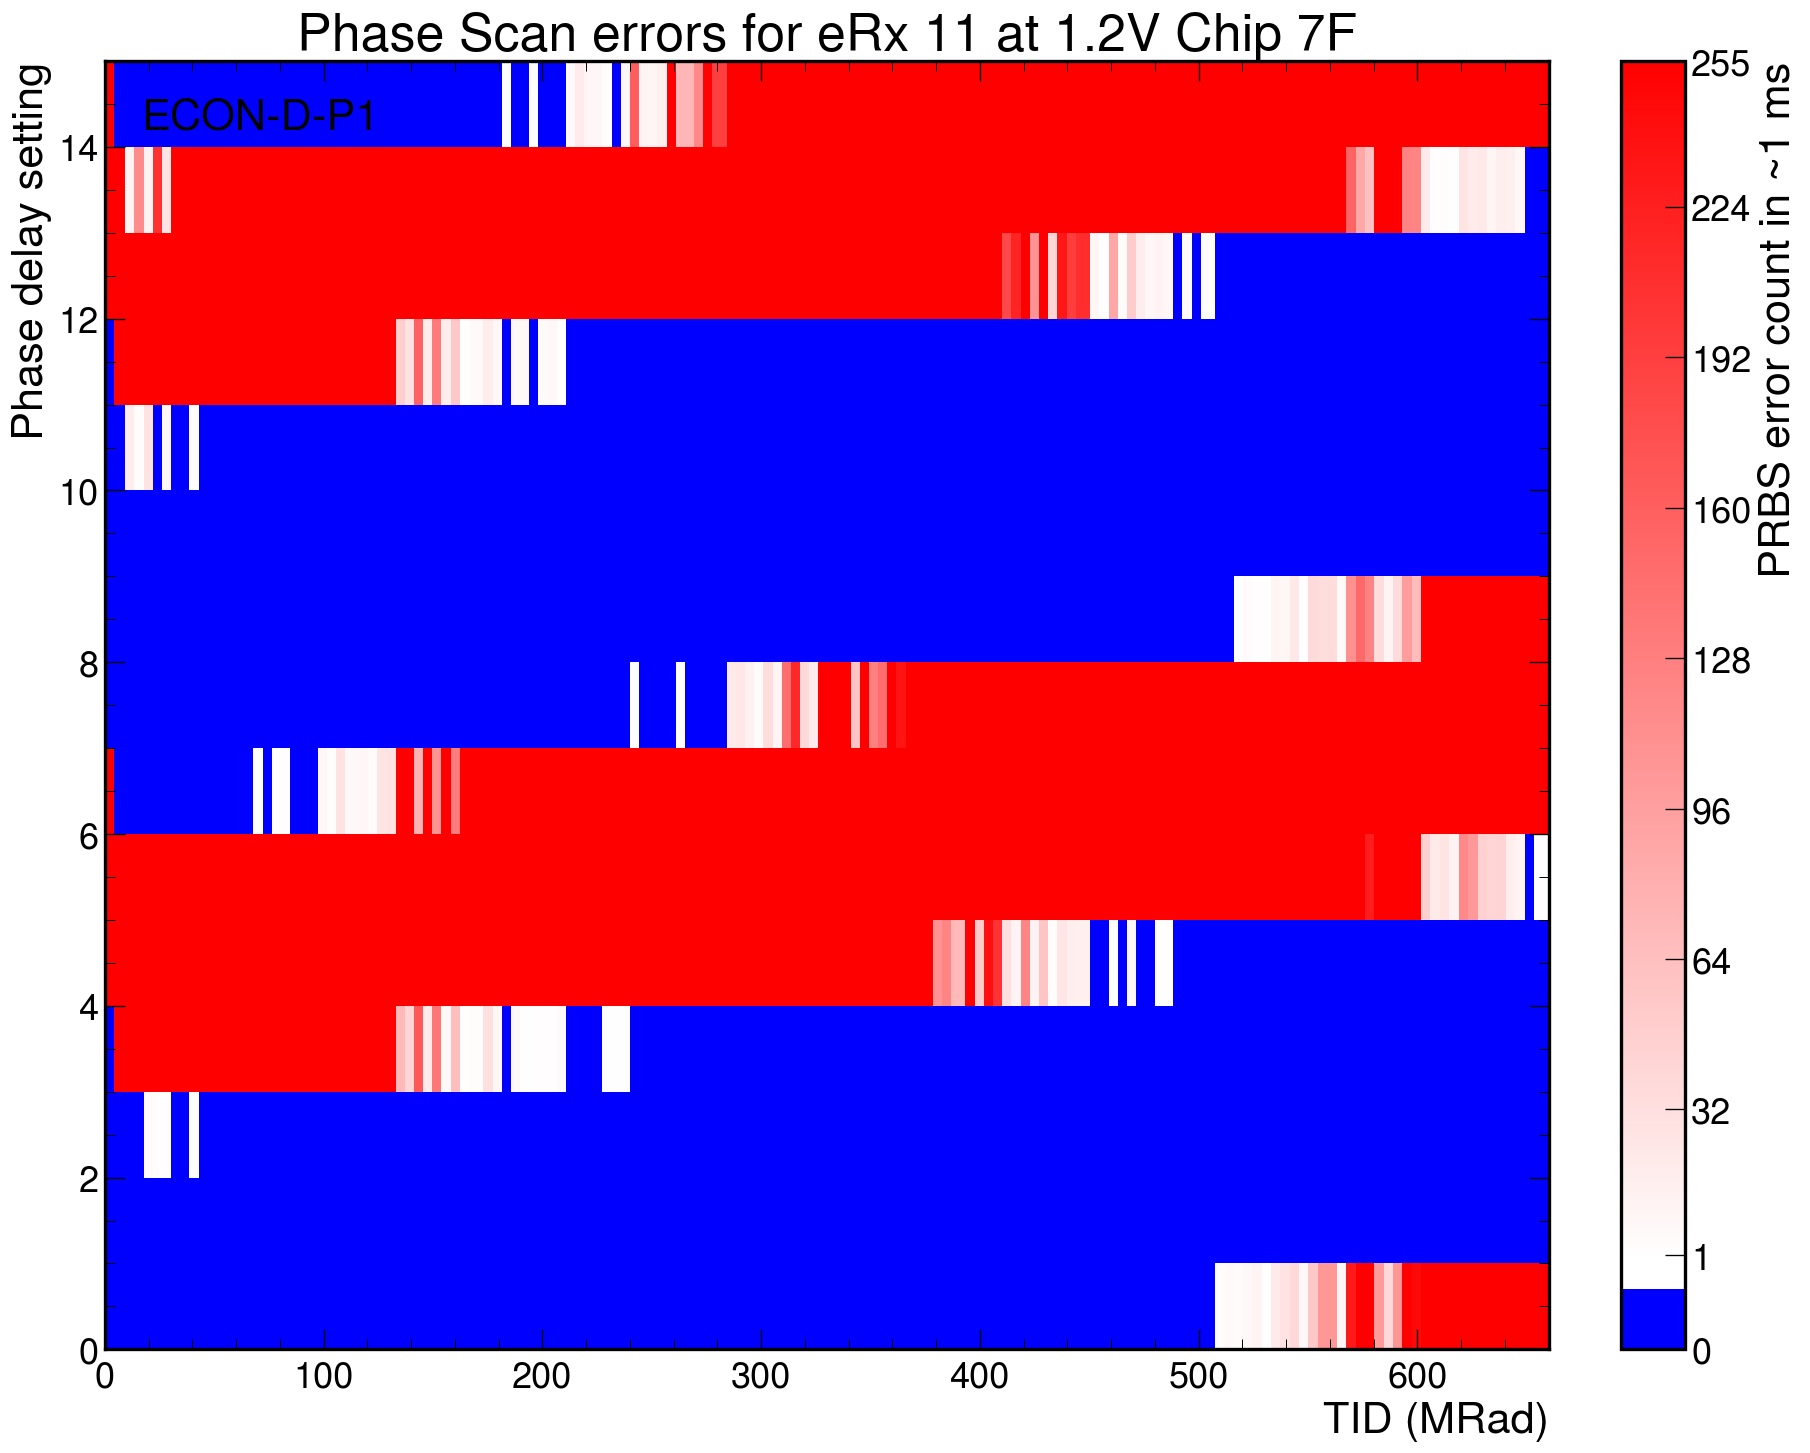

In [51]:
fig,axs=plt.subplots(figsize=(15,12), dpi=120, layout="constrained")
keylist = [1.08,1.11,1.14,1.20,1.26,1.29,1.32]
norm = mcolors.TwoSlopeNorm(vmin=0, vmax = 255, vcenter = 0.99)
nTrials = len(norm_errs_results_43[1.08])
a,b=np.meshgrid(megarad_dose,np.arange(15))
rand = nTrials + 1
chData = norm_errs_results_43[1.20][:,:,11]
h =axs.hist2d(a.flatten(),b.flatten(),weights=chData.T.flatten(),bins=(megarad_dose_plots,np.arange(16)),cmap=jsw_cmap)
#plt.colorbar().set_label(label='Transmission errors',size=11)
axs.set_title(f"Phase Scan errors for eRx 11 at 1.2V Chip 7F")
axs.set_ylabel('Phase delay setting')
axs.set_xlabel('TID (MRad)')
axs.set_xlim(0,660)
cb=fig.colorbar(h[3], ax = axs,label='PRBS error count in ~1 ms')
cb._set_scale(matplotlib.scale.FuncScale(cb._long_axis(), (forward, inverse)))
cb.set_ticks([0, 1, 32, 64, 96, 128, 160, 192, 224, 255])
cb.set_ticks([], minor=True)
axs.legend(loc='upper left', framealpha=1, title='ECON-D-P1')

fig.savefig("/Users/alexcampbell/Documents/Research/Fermilab/PLLLockingrange/plots/phase_scan_presentation_chip7.pdf", format="pdf", bbox_inches="tight")

# Temperature vs Time

In [85]:
def temperature_vs_time(frequency):
    temperature = []
    ts = []
    voltages = []
    for i in range(len(data)):
        for j in range(len(data[i]['tests'])):
            if "metadata" in data[i]['tests'][j]:
                if "automatic_capbank_setting" in data[i]['tests'][j]['metadata']:
                    if f"-{frequency}]" in data[i]['tests'][j]['nodeid']:
                        temperature.append(data[i]['tests'][j]['metadata']['Temperature'])
                        ts.append((data[i]['tests'][j]['metadata']['Timestamp']))
                        voltages.append(data[i]['tests'][j]['metadata']['voltage'])

    temperature_1_2 = []
    temperature_1_08 = []
    temperature_1_11 = []
    temperature_1_14 = []
    temperature_1_26 = []
    temperature_1_29 = []
    temperature_1_32 = []
    ts_1_2 = []
    ts_1_08 = []
    ts_1_11 = []
    ts_1_14 = []
    ts_1_26 = []
    ts_1_29 = []
    ts_1_32 = []


    for i in range(len(voltages)):
        if voltages[i] == 1.2:
            temperature_1_2.append(temperature[i])
            ts_1_2.append(ts[i])
        elif voltages[i] == 1.08:
            temperature_1_08.append(temperature[i])
            ts_1_08.append(ts[i])
        elif voltages[i] == 1.11:
            temperature_1_11.append(temperature[i])
            ts_1_11.append(ts[i])
        elif voltages[i] == 1.14:
            temperature_1_14.append(temperature[i])
            ts_1_14.append(ts[i])
        elif voltages[i] == 1.26:
            temperature_1_26.append(temperature[i])
            ts_1_26.append(ts[i])
        elif voltages[i] == 1.29:
            temperature_1_29.append(temperature[i])
            ts_1_29.append(ts[i])
        elif voltages[i] == 1.32:
            temperature_1_32.append(temperature[i])
            ts_1_32.append(ts[i])

    temperature_1_2_tot = []
    ts_1_2_tot = []
    for i in range (len(temperature_1_2)):
        for j in range(len(temperature_1_2[i])):
            temperature_1_2_tot.append(temperature_1_2[i][j])
            ts_1_2_tot.append(ts_1_2[i][j])

    temperature_1_08_tot = []
    ts_1_08_tot = []
    for i in range (len(temperature_1_08)):
        for j in range(len(temperature_1_08[i])):
            temperature_1_08_tot.append(temperature_1_08[i][j])
            ts_1_08_tot.append(ts_1_08[i][j])
    temperature_1_11_tot = []
    ts_1_11_tot = []
    for i in range (len(temperature_1_11)):
        for j in range(len(temperature_1_11[i])):
            temperature_1_11_tot.append(temperature_1_11[i][j])
            ts_1_11_tot.append(ts_1_11[i][j])
    temperature_1_14_tot = []
    ts_1_14_tot = []
    for i in range (len(temperature_1_14)):
        for j in range(len(temperature_1_14[i])):
            temperature_1_14_tot.append(temperature_1_14[i][j])
            ts_1_14_tot.append(ts_1_14[i][j])
    temperature_1_26_tot = []
    ts_1_26_tot = []
    for i in range (len(temperature_1_26)):
        for j in range(len(temperature_1_26[i])):
            temperature_1_26_tot.append(temperature_1_26[i][j])
            ts_1_26_tot.append(ts_1_26[i][j])
    temperature_1_29_tot = []
    ts_1_29_tot = []
    for i in range (len(temperature_1_29)):
        for j in range(len(temperature_1_29[i])):
            temperature_1_29_tot.append(temperature_1_29[i][j])
            ts_1_29_tot.append(ts_1_29[i][j])
    temperature_1_32_tot = []
    ts_1_32_tot = []
    for i in range (len(temperature_1_32)):
        for j in range(len(temperature_1_32[i])):
            temperature_1_32_tot.append(temperature_1_32[i][j])
            ts_1_32_tot.append(ts_1_32[i][j])

    temperatures = [temperature_1_08_tot, temperature_1_11_tot, temperature_1_14_tot, temperature_1_2_tot, temperature_1_26_tot,
                temperature_1_29_tot, temperature_1_32_tot]

    tss = [ts_1_08_tot, ts_1_11_tot, ts_1_14_tot, ts_1_2_tot, ts_1_26_tot, ts_1_29_tot, ts_1_32_tot]

    megarad_dose = []
    for i in range(7):
        tss[i] = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f") for x in tss[i] ]
        delTimes = [x - goodTimes[0] for x in tss[i]]
        delTimes = np.array(delTimes)
        delTimes = delTimes/timedelta(minutes=1)
        rad_dose = 9.2/60
        megarad_dose.append(rad_dose*delTimes)

    fig,axs=plt.subplots(figsize=(70,12),ncols=7,nrows=1, layout="constrained")

    keylist = [1.08,1.11,1.14,1.20,1.26,1.29,1.32]
    for i in range(len(keylist)):
        axs[i].scatter(megarad_dose[i],temperatures[i])
        axs[i].set_title(f"{keylist[i]}V - {frequency} MHz")
        axs[i].set_ylabel('Temperature (C)')
        axs[i].set_xlabel('TID (MRad)')
        axs[i].set_ylim(-23,0)
        axs[i].set_xlim(0,660)
    
            
    for ax in axs.flat:
        ax.label_outer()
    fig.savefig(f'./temperature_measurements_{frequency}.jpg')        

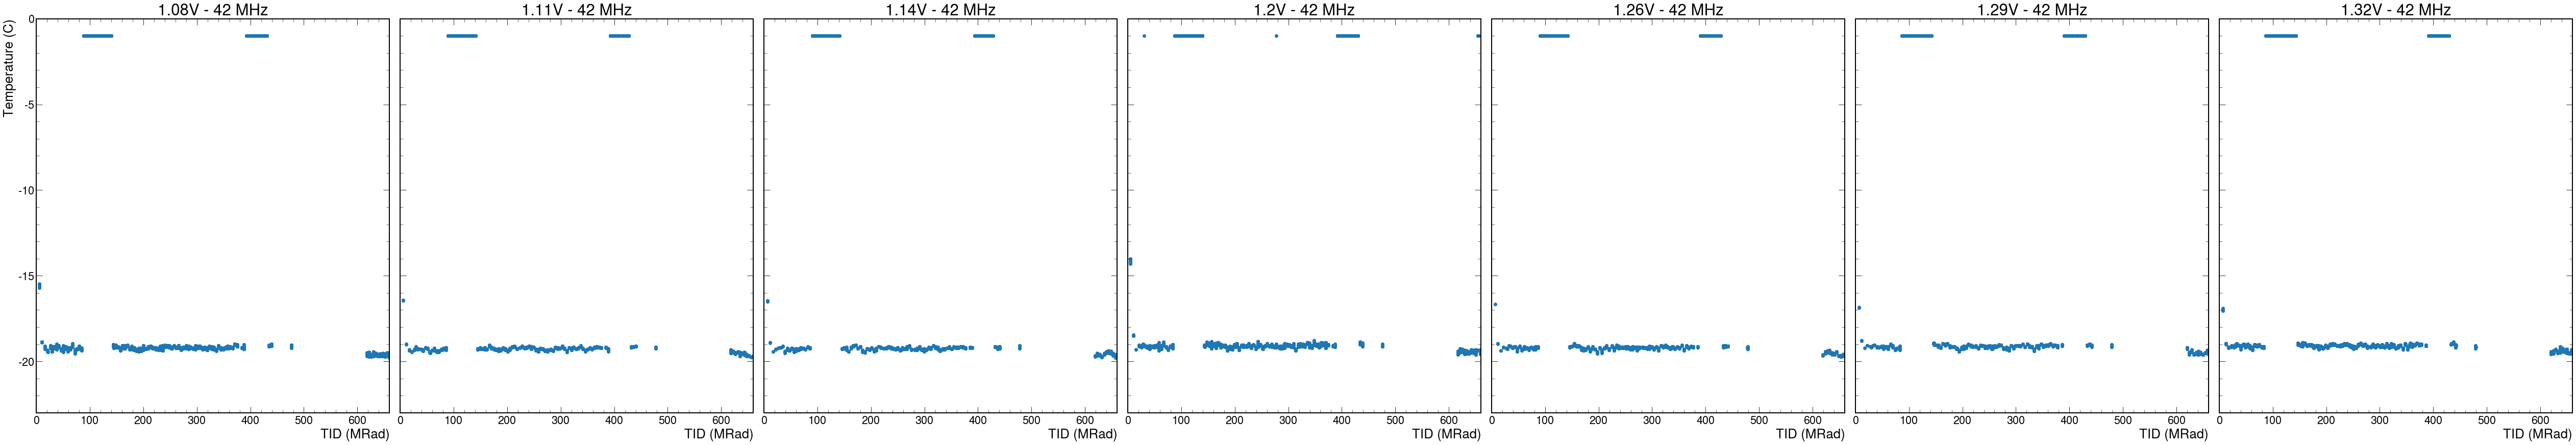

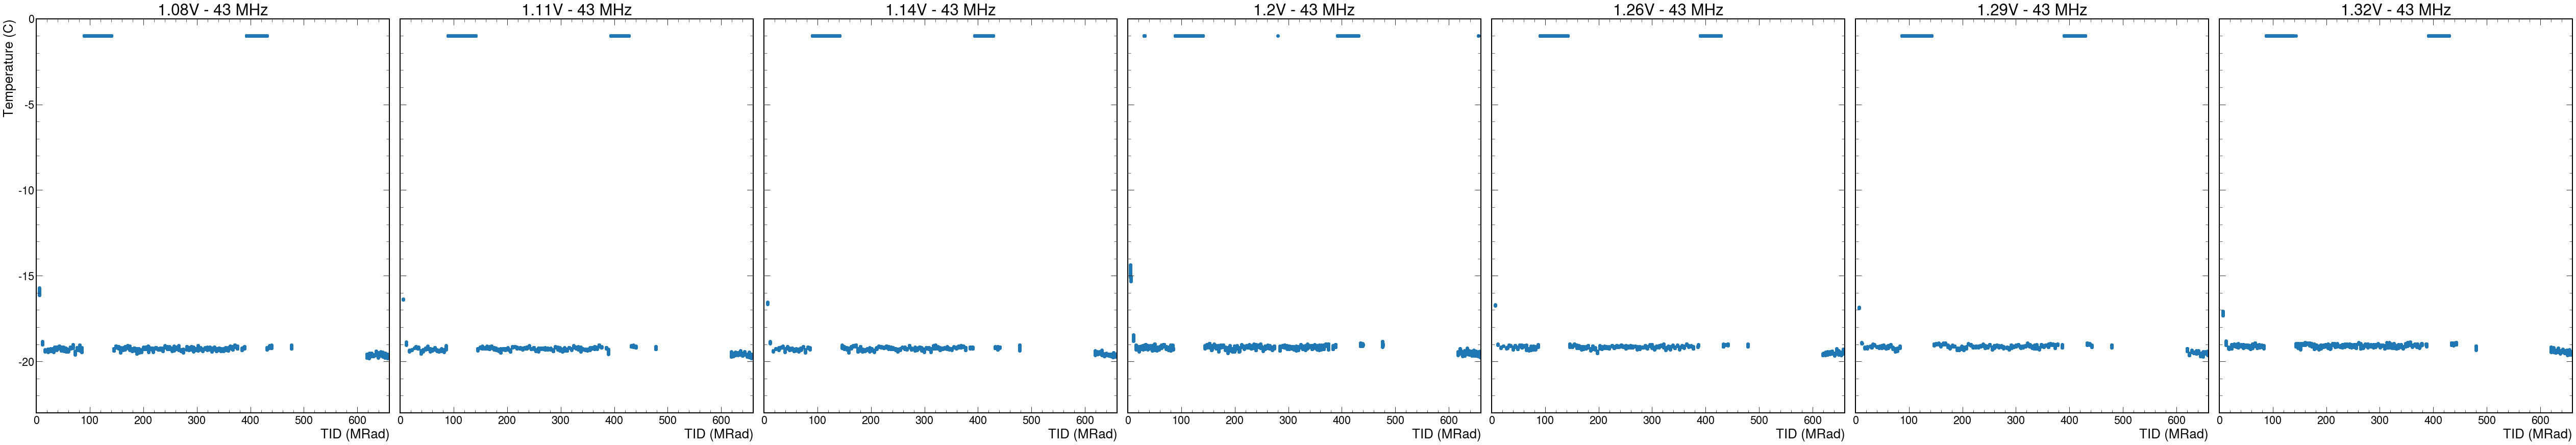

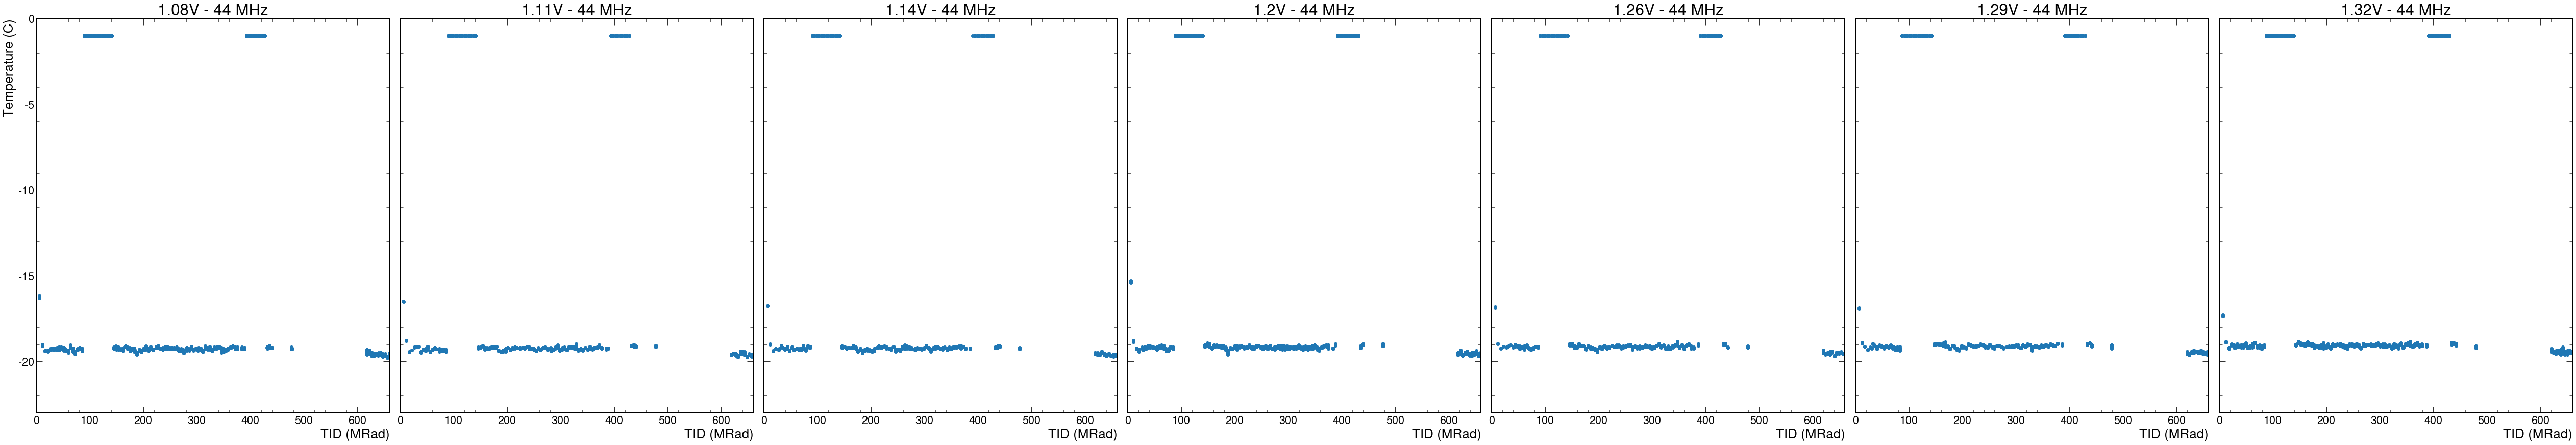

In [86]:
for freq in [42,43,44]:
    temperature_vs_time(freq)

# Error Count and Power Consumption

In [89]:
def error_count(frequency):
    worderrcnt = []
    hasl1a = []
    voltages = []
    wordCounts = []
    errorCounts = []
    timestamps=[]
    for i in range(len(data)):
        for j in range(len(data[i]['tests'])):
            if "metadata" in data[i]['tests'][j]:
                if "automatic_capbank_setting" in data[i]['tests'][j]['metadata']:
                    if f"-{frequency}]" in data[i]['tests'][j]['nodeid']:
                        if "HasL1A" in data[i]['tests'][j]['metadata']:
                            x = (data[i]['tests'][j]['metadata']['word_err_count'])
                            voltages.append(data[i]['tests'][j]['metadata']['Voltage'])
                            hasl1a.append(data[i]['tests'][j]['metadata']['HasL1A'])
                            worderrcnt.append(data[i]['tests'][j]['metadata']['word_err_count'])
                            y=np.array(x)
                            timestamps += list(y[:,0])
                            z=y[:,1].astype(int)
                            wordCounts += list(z + np.array([0] + list(np.cumsum(((z[1:]<z[:-1]))*1)*2**32)))

                            z=y[:,2].astype(int)
                            errorCounts += list(z + np.array([0] + list(np.cumsum(((z[1:]<z[:-1]))*1)*2**32)))

    timestamps=np.array(timestamps)
    newwordCounts = np.zeros(len(wordCounts))
    newerrorCounts = np.zeros(len(errorCounts))
    for i in range(len(wordCounts)-1):
        newwordCounts[i] = wordCounts[i+1] - wordCounts[i]
        newerrorCounts[i] = errorCounts[i+1] - errorCounts[i]


    voltages_used = []
    hasl1a_tot = []

    for i in range(len(worderrcnt)):
        for j in range(len(worderrcnt[i][:])):
            voltages_used.append(voltages[i][j])
            hasl1a_tot.append(hasl1a[i][j])

    errs_1_2_l1a = []
    errs_1_08_l1a = []
    errs_1_11_l1a = []
    errs_1_14_l1a = []
    errs_1_26_l1a = []
    errs_1_29_l1a = []
    errs_1_32_l1a = []

    errs_1_2_nol1a = []
    errs_1_08_nol1a = []
    errs_1_11_nol1a = []
    errs_1_14_nol1a = []
    errs_1_26_nol1a = []
    errs_1_29_nol1a = []
    errs_1_32_nol1a = []

    wordcnt_1_2_l1a = []
    wordcnt_1_08_l1a = []
    wordcnt_1_11_l1a = []
    wordcnt_1_14_l1a = []
    wordcnt_1_26_l1a = []
    wordcnt_1_29_l1a = []
    wordcnt_1_32_l1a = []

    wordcnt_1_2_nol1a = []
    wordcnt_1_08_nol1a = []
    wordcnt_1_11_nol1a = []
    wordcnt_1_14_nol1a = []
    wordcnt_1_26_nol1a = []
    wordcnt_1_29_nol1a = []
    wordcnt_1_32_nol1a = []

    timestamps_1_2_l1a = []
    timestamps_1_08_l1a = []
    timestamps_1_11_l1a = []
    timestamps_1_14_l1a = []
    timestamps_1_26_l1a = []
    timestamps_1_29_l1a = []
    timestamps_1_32_l1a = []

    timestamps_1_2_nol1a = []
    timestamps_1_08_nol1a = []
    timestamps_1_11_nol1a = []
    timestamps_1_14_nol1a = []
    timestamps_1_26_nol1a = []
    timestamps_1_29_nol1a = []
    timestamps_1_32_nol1a = []

    for i in range(len(voltages_used)):
        if voltages_used[i] >= 1.19 and voltages_used[i] <= 1.21:
            if hasl1a_tot[i] == 1:
                errs_1_2_l1a.append(newerrorCounts[i])
                timestamps_1_2_l1a.append(timestamps[i])
                wordcnt_1_2_l1a.append(newwordCounts[i])
            else:
                errs_1_2_nol1a.append(newerrorCounts[i])
                wordcnt_1_2_nol1a.append(newwordCounts[i])
                timestamps_1_2_nol1a.append(timestamps[i])
        elif voltages_used[i] >= 1.07 and voltages_used[i] <= 1.09:
            if hasl1a_tot[i] == 1:
                errs_1_08_l1a.append(newerrorCounts[i])
                timestamps_1_08_l1a.append(timestamps[i])
                wordcnt_1_08_l1a.append(newwordCounts[i])
            else:
                errs_1_08_nol1a.append(newerrorCounts[i])
                wordcnt_1_08_nol1a.append(newwordCounts[i])
                timestamps_1_08_nol1a.append(timestamps[i])
        elif voltages_used[i] >= 1.10 and voltages_used[i] <= 1.12:
            if hasl1a_tot[i] == 1:
                errs_1_11_l1a.append(newerrorCounts[i])
                timestamps_1_11_l1a.append(timestamps[i])
                wordcnt_1_11_l1a.append(newwordCounts[i])
            else:
                errs_1_11_nol1a.append(newerrorCounts[i])
                wordcnt_1_11_nol1a.append(newwordCounts[i])
                timestamps_1_11_nol1a.append(timestamps[i])
        elif voltages_used[i] >= 1.13 and voltages_used[i] <= 1.15:
            if hasl1a_tot[i] == 1:
                errs_1_14_l1a.append(newerrorCounts[i])
                timestamps_1_14_l1a.append(timestamps[i])
                wordcnt_1_14_l1a.append(newwordCounts[i])
            else:
                errs_1_14_nol1a.append(newerrorCounts[i])
                timestamps_1_14_nol1a.append(timestamps[i])
                wordcnt_1_14_nol1a.append(newwordCounts[i])
        elif voltages_used[i] >= 1.25 and voltages_used[i] <= 1.27:
            if hasl1a_tot[i] == 1:
                errs_1_26_l1a.append(newerrorCounts[i])
                timestamps_1_26_l1a.append(timestamps[i])
                wordcnt_1_26_l1a.append(newwordCounts[i])
            else:
                errs_1_26_nol1a.append(newerrorCounts[i])
                wordcnt_1_26_nol1a.append(newwordCounts[i])
                timestamps_1_26_nol1a.append(timestamps[i])
        elif voltages_used[i] >= 1.28 and voltages_used[i] <= 1.30:
            if hasl1a_tot[i] == 1:
                errs_1_29_l1a.append(newerrorCounts[i])
                timestamps_1_29_l1a.append(timestamps[i])
                wordcnt_1_29_l1a.append(newwordCounts[i])
            else:
                errs_1_29_nol1a.append(newerrorCounts[i])
                wordcnt_1_29_nol1a.append(newwordCounts[i])
                timestamps_1_29_nol1a.append(timestamps[i])
        elif voltages_used[i] >= 1.31 and voltages_used[i] <= 1.32:
            if hasl1a_tot[i] == 1:
                errs_1_32_l1a.append(newerrorCounts[i])
                timestamps_1_32_l1a.append(timestamps[i])
                wordcnt_1_32_l1a.append(newwordCounts[i])
            else:
                errs_1_32_nol1a.append(newerrorCounts[i])
                wordcnt_1_32_nol1a.append(newwordCounts[i])
                timestamps_1_32_nol1a.append(timestamps[i])

    errs_1_2_l1a = np.array(errs_1_2_l1a)
    errs_1_08_l1a = np.array(errs_1_08_l1a)
    errs_1_11_l1a = np.array(errs_1_11_l1a)
    errs_1_14_l1a = np.array(errs_1_14_l1a)
    errs_1_26_l1a = np.array(errs_1_26_l1a)
    errs_1_29_l1a = np.array(errs_1_29_l1a)
    errs_1_32_l1a = np.array(errs_1_32_l1a)

    errs_1_2_nol1a = np.array(errs_1_2_nol1a)
    errs_1_08_nol1a = np.array(errs_1_08_nol1a)
    errs_1_11_nol1a = np.array(errs_1_11_nol1a)
    errs_1_14_nol1a = np.array(errs_1_14_nol1a)
    errs_1_26_nol1a = np.array(errs_1_26_nol1a)
    errs_1_29_nol1a = np.array(errs_1_29_nol1a)
    errs_1_32_nol1a = np.array(errs_1_32_nol1a)

    wordcnt_1_2_l1a = np.array(wordcnt_1_2_l1a)
    wordcnt_1_08_l1a = np.array(wordcnt_1_08_l1a)
    wordcnt_1_11_l1a = np.array(wordcnt_1_11_l1a)
    wordcnt_1_14_l1a = np.array(wordcnt_1_14_l1a)
    wordcnt_1_26_l1a = np.array(wordcnt_1_26_l1a)
    wordcnt_1_29_l1a = np.array(wordcnt_1_29_l1a)
    wordcnt_1_32_l1a = np.array(wordcnt_1_32_l1a)

    wordcnt_1_2_nol1a = np.array(wordcnt_1_2_nol1a)
    wordcnt_1_08_nol1a = np.array(wordcnt_1_08_nol1a)
    wordcnt_1_11_nol1a = np.array(wordcnt_1_11_nol1a)
    wordcnt_1_14_nol1a = np.array(wordcnt_1_14_nol1a)
    wordcnt_1_26_nol1a = np.array(wordcnt_1_26_nol1a)
    wordcnt_1_29_nol1a = np.array(wordcnt_1_29_nol1a)
    wordcnt_1_32_nol1a = np.array(wordcnt_1_32_nol1a)

    errs_rate_1_2_l1a = errs_1_2_l1a/wordcnt_1_2_l1a
    errs_rate_1_08_l1a = errs_1_08_l1a/wordcnt_1_08_l1a
    errs_rate_1_11_l1a = errs_1_11_l1a/wordcnt_1_11_l1a
    errs_rate_1_14_l1a = errs_1_14_l1a/wordcnt_1_14_l1a
    errs_rate_1_26_l1a = errs_1_26_l1a/wordcnt_1_26_l1a
    errs_rate_1_29_l1a = errs_1_29_l1a/wordcnt_1_29_l1a
    errs_rate_1_32_l1a = errs_1_32_l1a/wordcnt_1_32_l1a

    errs_rate_1_2_nol1a = errs_1_2_nol1a/wordcnt_1_2_nol1a
    errs_rate_1_08_nol1a = errs_1_08_nol1a/wordcnt_1_08_nol1a
    errs_rate_1_11_nol1a = errs_1_11_nol1a/wordcnt_1_11_nol1a
    errs_rate_1_14_nol1a = errs_1_14_nol1a/wordcnt_1_14_nol1a
    errs_rate_1_26_nol1a = errs_1_26_nol1a/wordcnt_1_26_nol1a
    errs_rate_1_29_nol1a = errs_1_29_nol1a/wordcnt_1_29_nol1a
    errs_rate_1_32_nol1a = errs_1_32_nol1a/wordcnt_1_32_nol1a

    errs_l1a = [errs_1_08_l1a, errs_1_11_l1a, errs_1_14_l1a, errs_1_2_l1a, errs_1_26_l1a, errs_1_29_l1a, errs_1_32_l1a]
    errs_nol1a = [errs_1_08_nol1a, errs_1_11_nol1a, errs_1_14_nol1a, errs_1_2_nol1a, errs_1_26_nol1a, errs_1_29_nol1a, errs_1_32_nol1a]
    wordcnt_l1a = [wordcnt_1_08_l1a, wordcnt_1_11_l1a, wordcnt_1_14_l1a, wordcnt_1_2_l1a, wordcnt_1_26_l1a, wordcnt_1_29_l1a, wordcnt_1_32_l1a]
    wordcnt_nol1a = [wordcnt_1_08_nol1a, wordcnt_1_11_nol1a, wordcnt_1_14_nol1a, wordcnt_1_2_nol1a, wordcnt_1_26_nol1a, wordcnt_1_29_nol1a, wordcnt_1_32_nol1a]           
    errs_rate_nol1a = [errs_rate_1_08_nol1a, errs_rate_1_11_nol1a, errs_rate_1_14_nol1a, errs_rate_1_2_nol1a, errs_rate_1_26_nol1a, errs_rate_1_29_nol1a, errs_rate_1_32_nol1a]
    errs_rate_l1a = [errs_rate_1_08_l1a, errs_rate_1_11_l1a, errs_rate_1_14_l1a, errs_rate_1_2_l1a, errs_rate_1_26_l1a, errs_rate_1_29_l1a, errs_rate_1_32_l1a]
    tssl1a = [timestamps_1_08_l1a, timestamps_1_11_l1a, timestamps_1_14_l1a, timestamps_1_2_l1a, timestamps_1_26_l1a, timestamps_1_29_l1a, timestamps_1_32_l1a]
    tssnol1a = [timestamps_1_08_nol1a, timestamps_1_11_nol1a, timestamps_1_14_nol1a, timestamps_1_2_nol1a, timestamps_1_26_nol1a, timestamps_1_29_nol1a, timestamps_1_32_nol1a]

    megarad_dose_l1a = []
    for i in range(7):
        tssl1a[i] = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f") for x in tssl1a[i] ]
        delTimes = [x - goodTimes[0] for x in tssl1a[i]]
        delTimes = np.array(delTimes)
        delTimes = delTimes/timedelta(minutes=1)
        rad_dose = 9.2/60
        megarad_dose_l1a.append(rad_dose*delTimes)

    megarad_dose_nol1a = []
    for i in range(7):
        tssnol1a[i] = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f") for x in tssnol1a[i] ]
        delTimes = [x - goodTimes[0] for x in tssnol1a[i]]
        delTimes = np.array(delTimes)
        delTimes = delTimes/timedelta(minutes=1)
        rad_dose = 9.2/60
        megarad_dose_nol1a.append(rad_dose*delTimes)

    fig,axs=plt.subplots(figsize=(45,12),ncols=7,nrows=3, layout="constrained")
    keylist = [1.08,1.11,1.14,1.20,1.26,1.29,1.32]
    for j in range(len(keylist)):
        for i in range(3):
            if i == 0:
                axs[i,j].scatter(megarad_dose_l1a[j], errs_l1a[j], label = "errors w l1a", color = "r")
                axs[i,j].scatter(megarad_dose_nol1a[j], errs_nol1a[j], label = "errors w/o l1a",facecolors='none', edgecolors='b')
                axs[i,j].set_ylabel("SC Errors")
                axs[i,j].set_xlabel("TID (MRad)")
                axs[i,j].set_title(f"{keylist[j]}V - {frequency} MHz")
                axs[i,j].set_yscale("log")
                axs[i,j].set_ylim((1,1e10))
                axs[i,j].set_xlim(0,660)

                
        
                
            if i == 1:
                axs[i,j].scatter(megarad_dose_l1a[j], wordcnt_l1a[j], label = "errors w l1a", color = "r")
                axs[i,j].scatter(megarad_dose_nol1a[j],wordcnt_nol1a[j], label = "errors w/o l1a",facecolors='none', edgecolors='b')
                axs[i,j].set_ylabel("Word Count")
                axs[i,j].set_xlabel("TID (MRad)")
                axs[i,j].set_title(f"{keylist[j]}V - {frequency} MHz")
                axs[i,j].set_yscale("log")
                axs[i,j].set_ylim((1,1e10))
                axs[i,j].set_xlim(0,660)

                
            if i == 2:
                axs[i,j].scatter(megarad_dose_l1a[j], errs_rate_l1a[j], label = "errors w l1a", color = "r")
                axs[i,j].scatter(megarad_dose_nol1a[j], errs_rate_nol1a[j], label = "errors w/o l1a",facecolors='none', edgecolors='b')
                axs[i,j].set_ylabel("Error Rate")
                axs[i,j].set_xlabel("TID (MRad)")
                axs[i,j].set_title(f"{keylist[j]}V - {frequency} MHz")
                axs[i,j].set_yscale("log")
                axs[i,j].set_ylim((1e-8,1.1))
                axs[i,j].set_xlim(0,660)

    for ax in axs.flat:
        ax.label_outer()
    fig.savefig(f'./word_err_err_rate_results_{frequency}.jpg')

/var/folders/pj/jdsydbt93y3fty8bxll08bd00000gn/T/ipykernel_1320/2794242512.py:193: RuntimeWarning: invalid value encountered in true_divide
  errs_rate_1_32_l1a = errs_1_32_l1a/wordcnt_1_32_l1a


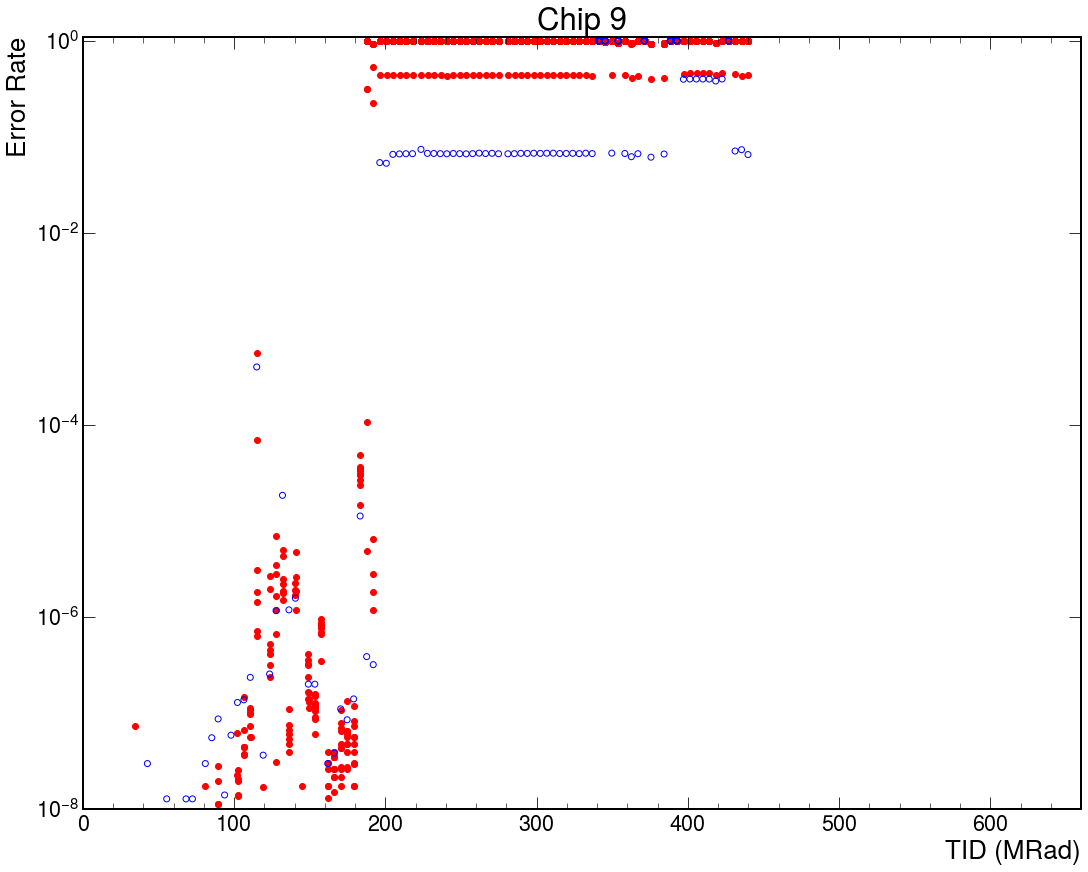

In [179]:
worderrcnt = []
hasl1a = []
voltages = []
wordCounts = []
errorCounts = []
timestamps=[]
frequency = 43
for i in range(len(data)):
    for j in range(len(data[i]['tests'])):
        if "metadata" in data[i]['tests'][j]:
            if "automatic_capbank_setting" in data[i]['tests'][j]['metadata']:
                if f"-{frequency}]" in data[i]['tests'][j]['nodeid']:
                    if "HasL1A" in data[i]['tests'][j]['metadata']:
                        x = (data[i]['tests'][j]['metadata']['word_err_count'])
                        voltages.append(data[i]['tests'][j]['metadata']['Voltage'])
                        hasl1a.append(data[i]['tests'][j]['metadata']['HasL1A'])
                        worderrcnt.append(data[i]['tests'][j]['metadata']['word_err_count'])
                        y=np.array(x)
                        timestamps += list(y[:,0])
                        z=y[:,1].astype(int)
                        wordCounts += list(z + np.array([0] + list(np.cumsum(((z[1:]<z[:-1]))*1)*2**32)))

                        z=y[:,2].astype(int)
                        errorCounts += list(z + np.array([0] + list(np.cumsum(((z[1:]<z[:-1]))*1)*2**32)))

timestamps=np.array(timestamps)
newwordCounts = np.zeros(len(wordCounts))
newerrorCounts = np.zeros(len(errorCounts))
for i in range(len(wordCounts)-1):
    newwordCounts[i] = wordCounts[i+1] - wordCounts[i]
    newerrorCounts[i] = errorCounts[i+1] - errorCounts[i]


voltages_used = []
hasl1a_tot = []

for i in range(len(worderrcnt)):
    for j in range(len(worderrcnt[i][:])):
        voltages_used.append(voltages[i][j])
        hasl1a_tot.append(hasl1a[i][j])

errs_1_2_l1a = []
errs_1_08_l1a = []
errs_1_11_l1a = []
errs_1_14_l1a = []
errs_1_26_l1a = []
errs_1_29_l1a = []
errs_1_32_l1a = []

errs_1_2_nol1a = []
errs_1_08_nol1a = []
errs_1_11_nol1a = []
errs_1_14_nol1a = []
errs_1_26_nol1a = []
errs_1_29_nol1a = []
errs_1_32_nol1a = []

wordcnt_1_2_l1a = []
wordcnt_1_08_l1a = []
wordcnt_1_11_l1a = []
wordcnt_1_14_l1a = []
wordcnt_1_26_l1a = []
wordcnt_1_29_l1a = []
wordcnt_1_32_l1a = []

wordcnt_1_2_nol1a = []
wordcnt_1_08_nol1a = []
wordcnt_1_11_nol1a = []
wordcnt_1_14_nol1a = []
wordcnt_1_26_nol1a = []
wordcnt_1_29_nol1a = []
wordcnt_1_32_nol1a = []

timestamps_1_2_l1a = []
timestamps_1_08_l1a = []
timestamps_1_11_l1a = []
timestamps_1_14_l1a = []
timestamps_1_26_l1a = []
timestamps_1_29_l1a = []
timestamps_1_32_l1a = []

timestamps_1_2_nol1a = []
timestamps_1_08_nol1a = []
timestamps_1_11_nol1a = []
timestamps_1_14_nol1a = []
timestamps_1_26_nol1a = []
timestamps_1_29_nol1a = []
timestamps_1_32_nol1a = []

for i in range(len(voltages_used)):
    if voltages_used[i] >= 1.19 and voltages_used[i] <= 1.21:
        if hasl1a_tot[i] == 1:
            errs_1_2_l1a.append(newerrorCounts[i])
            timestamps_1_2_l1a.append(timestamps[i])
            wordcnt_1_2_l1a.append(newwordCounts[i])
        else:
            errs_1_2_nol1a.append(newerrorCounts[i])
            wordcnt_1_2_nol1a.append(newwordCounts[i])
            timestamps_1_2_nol1a.append(timestamps[i])
    elif voltages_used[i] >= 1.07 and voltages_used[i] <= 1.09:
        if hasl1a_tot[i] == 1:
            errs_1_08_l1a.append(newerrorCounts[i])
            timestamps_1_08_l1a.append(timestamps[i])
            wordcnt_1_08_l1a.append(newwordCounts[i])
        else:
            errs_1_08_nol1a.append(newerrorCounts[i])
            wordcnt_1_08_nol1a.append(newwordCounts[i])
            timestamps_1_08_nol1a.append(timestamps[i])
    elif voltages_used[i] >= 1.10 and voltages_used[i] <= 1.12:
        if hasl1a_tot[i] == 1:
            errs_1_11_l1a.append(newerrorCounts[i])
            timestamps_1_11_l1a.append(timestamps[i])
            wordcnt_1_11_l1a.append(newwordCounts[i])
        else:
            errs_1_11_nol1a.append(newerrorCounts[i])
            wordcnt_1_11_nol1a.append(newwordCounts[i])
            timestamps_1_11_nol1a.append(timestamps[i])
    elif voltages_used[i] >= 1.13 and voltages_used[i] <= 1.15:
        if hasl1a_tot[i] == 1:
            errs_1_14_l1a.append(newerrorCounts[i])
            timestamps_1_14_l1a.append(timestamps[i])
            wordcnt_1_14_l1a.append(newwordCounts[i])
        else:
            errs_1_14_nol1a.append(newerrorCounts[i])
            timestamps_1_14_nol1a.append(timestamps[i])
            wordcnt_1_14_nol1a.append(newwordCounts[i])
    elif voltages_used[i] >= 1.25 and voltages_used[i] <= 1.27:
        if hasl1a_tot[i] == 1:
            errs_1_26_l1a.append(newerrorCounts[i])
            timestamps_1_26_l1a.append(timestamps[i])
            wordcnt_1_26_l1a.append(newwordCounts[i])
        else:
            errs_1_26_nol1a.append(newerrorCounts[i])
            wordcnt_1_26_nol1a.append(newwordCounts[i])
            timestamps_1_26_nol1a.append(timestamps[i])
    elif voltages_used[i] >= 1.28 and voltages_used[i] <= 1.30:
        if hasl1a_tot[i] == 1:
            errs_1_29_l1a.append(newerrorCounts[i])
            timestamps_1_29_l1a.append(timestamps[i])
            wordcnt_1_29_l1a.append(newwordCounts[i])
        else:
            errs_1_29_nol1a.append(newerrorCounts[i])
            wordcnt_1_29_nol1a.append(newwordCounts[i])
            timestamps_1_29_nol1a.append(timestamps[i])
    elif voltages_used[i] >= 1.31 and voltages_used[i] <= 1.32:
        if hasl1a_tot[i] == 1:
            errs_1_32_l1a.append(newerrorCounts[i])
            timestamps_1_32_l1a.append(timestamps[i])
            wordcnt_1_32_l1a.append(newwordCounts[i])
        else:
            errs_1_32_nol1a.append(newerrorCounts[i])
            wordcnt_1_32_nol1a.append(newwordCounts[i])
            timestamps_1_32_nol1a.append(timestamps[i])

errs_1_2_l1a = np.array(errs_1_2_l1a)
errs_1_08_l1a = np.array(errs_1_08_l1a)
errs_1_11_l1a = np.array(errs_1_11_l1a)
errs_1_14_l1a = np.array(errs_1_14_l1a)
errs_1_26_l1a = np.array(errs_1_26_l1a)
errs_1_29_l1a = np.array(errs_1_29_l1a)
errs_1_32_l1a = np.array(errs_1_32_l1a)

errs_1_2_nol1a = np.array(errs_1_2_nol1a)
errs_1_08_nol1a = np.array(errs_1_08_nol1a)
errs_1_11_nol1a = np.array(errs_1_11_nol1a)
errs_1_14_nol1a = np.array(errs_1_14_nol1a)
errs_1_26_nol1a = np.array(errs_1_26_nol1a)
errs_1_29_nol1a = np.array(errs_1_29_nol1a)
errs_1_32_nol1a = np.array(errs_1_32_nol1a)

wordcnt_1_2_l1a = np.array(wordcnt_1_2_l1a)
wordcnt_1_08_l1a = np.array(wordcnt_1_08_l1a)
wordcnt_1_11_l1a = np.array(wordcnt_1_11_l1a)
wordcnt_1_14_l1a = np.array(wordcnt_1_14_l1a)
wordcnt_1_26_l1a = np.array(wordcnt_1_26_l1a)
wordcnt_1_29_l1a = np.array(wordcnt_1_29_l1a)
wordcnt_1_32_l1a = np.array(wordcnt_1_32_l1a)

wordcnt_1_2_nol1a = np.array(wordcnt_1_2_nol1a)
wordcnt_1_08_nol1a = np.array(wordcnt_1_08_nol1a)
wordcnt_1_11_nol1a = np.array(wordcnt_1_11_nol1a)
wordcnt_1_14_nol1a = np.array(wordcnt_1_14_nol1a)
wordcnt_1_26_nol1a = np.array(wordcnt_1_26_nol1a)
wordcnt_1_29_nol1a = np.array(wordcnt_1_29_nol1a)
wordcnt_1_32_nol1a = np.array(wordcnt_1_32_nol1a)

errs_rate_1_2_l1a = errs_1_2_l1a/wordcnt_1_2_l1a
errs_rate_1_08_l1a = errs_1_08_l1a/wordcnt_1_08_l1a
errs_rate_1_11_l1a = errs_1_11_l1a/wordcnt_1_11_l1a
errs_rate_1_14_l1a = errs_1_14_l1a/wordcnt_1_14_l1a
errs_rate_1_26_l1a = errs_1_26_l1a/wordcnt_1_26_l1a
errs_rate_1_29_l1a = errs_1_29_l1a/wordcnt_1_29_l1a
errs_rate_1_32_l1a = errs_1_32_l1a/wordcnt_1_32_l1a

errs_rate_1_2_nol1a = errs_1_2_nol1a/wordcnt_1_2_nol1a
errs_rate_1_08_nol1a = errs_1_08_nol1a/wordcnt_1_08_nol1a
errs_rate_1_11_nol1a = errs_1_11_nol1a/wordcnt_1_11_nol1a
errs_rate_1_14_nol1a = errs_1_14_nol1a/wordcnt_1_14_nol1a
errs_rate_1_26_nol1a = errs_1_26_nol1a/wordcnt_1_26_nol1a
errs_rate_1_29_nol1a = errs_1_29_nol1a/wordcnt_1_29_nol1a
errs_rate_1_32_nol1a = errs_1_32_nol1a/wordcnt_1_32_nol1a

errs_l1a = [errs_1_08_l1a, errs_1_11_l1a, errs_1_14_l1a, errs_1_2_l1a, errs_1_26_l1a, errs_1_29_l1a, errs_1_32_l1a]
errs_nol1a = [errs_1_08_nol1a, errs_1_11_nol1a, errs_1_14_nol1a, errs_1_2_nol1a, errs_1_26_nol1a, errs_1_29_nol1a, errs_1_32_nol1a]
wordcnt_l1a = [wordcnt_1_08_l1a, wordcnt_1_11_l1a, wordcnt_1_14_l1a, wordcnt_1_2_l1a, wordcnt_1_26_l1a, wordcnt_1_29_l1a, wordcnt_1_32_l1a]
wordcnt_nol1a = [wordcnt_1_08_nol1a, wordcnt_1_11_nol1a, wordcnt_1_14_nol1a, wordcnt_1_2_nol1a, wordcnt_1_26_nol1a, wordcnt_1_29_nol1a, wordcnt_1_32_nol1a]           
errs_rate_nol1a = [errs_rate_1_08_nol1a, errs_rate_1_11_nol1a, errs_rate_1_14_nol1a, errs_rate_1_2_nol1a, errs_rate_1_26_nol1a, errs_rate_1_29_nol1a, errs_rate_1_32_nol1a]
errs_rate_l1a = [errs_rate_1_08_l1a, errs_rate_1_11_l1a, errs_rate_1_14_l1a, errs_rate_1_2_l1a, errs_rate_1_26_l1a, errs_rate_1_29_l1a, errs_rate_1_32_l1a]
tssl1a = [timestamps_1_08_l1a, timestamps_1_11_l1a, timestamps_1_14_l1a, timestamps_1_2_l1a, timestamps_1_26_l1a, timestamps_1_29_l1a, timestamps_1_32_l1a]
tssnol1a = [timestamps_1_08_nol1a, timestamps_1_11_nol1a, timestamps_1_14_nol1a, timestamps_1_2_nol1a, timestamps_1_26_nol1a, timestamps_1_29_nol1a, timestamps_1_32_nol1a]

megarad_dose_l1a = []
for i in range(7):
    tssl1a[i] = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f") for x in tssl1a[i] ]
    delTimes = [x - goodTimes[0] for x in tssl1a[i]]
    delTimes = np.array(delTimes)
    delTimes = delTimes/timedelta(minutes=1)
    rad_dose = 9.2/60
    megarad_dose_l1a.append(rad_dose*delTimes)

megarad_dose_nol1a = []
for i in range(7):
    tssnol1a[i] = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f") for x in tssnol1a[i] ]
    delTimes = [x - goodTimes[0] for x in tssnol1a[i]]
    delTimes = np.array(delTimes)
    delTimes = delTimes/timedelta(minutes=1)
    rad_dose = 9.2/60
    megarad_dose_nol1a.append(rad_dose*delTimes)

fig,axs=plt.subplots(figsize=(15,12), layout="constrained")
keylist = [1.08,1.11,1.14,1.20,1.26,1.29,1.32]

axs.scatter(megarad_dose_l1a[0], errs_rate_l1a[0], label = "errors w l1a", color = "r")
axs.scatter(megarad_dose_nol1a[0], errs_rate_nol1a[0], label = "errors w/o l1a",facecolors='none', edgecolors='b')
axs.set_ylabel("Error Rate")
axs.set_xlabel("TID (MRad)")
axs.set_title(f"Chip 9")
axs.set_yscale("log")
axs.set_ylim((1e-8,1.1))
axs.set_xlim(0,660)


fig.savefig(f'./word_err_err_rate_presentation_results_Chip9.jpg')

/var/folders/pj/jdsydbt93y3fty8bxll08bd00000gn/T/ipykernel_1320/2514384820.py:193: RuntimeWarning: invalid value encountered in true_divide
  errs_rate_1_32_l1a = errs_1_32_l1a/wordcnt_1_32_l1a
/var/folders/pj/jdsydbt93y3fty8bxll08bd00000gn/T/ipykernel_1320/2514384820.py:264: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[i,j].set_yscale("log")


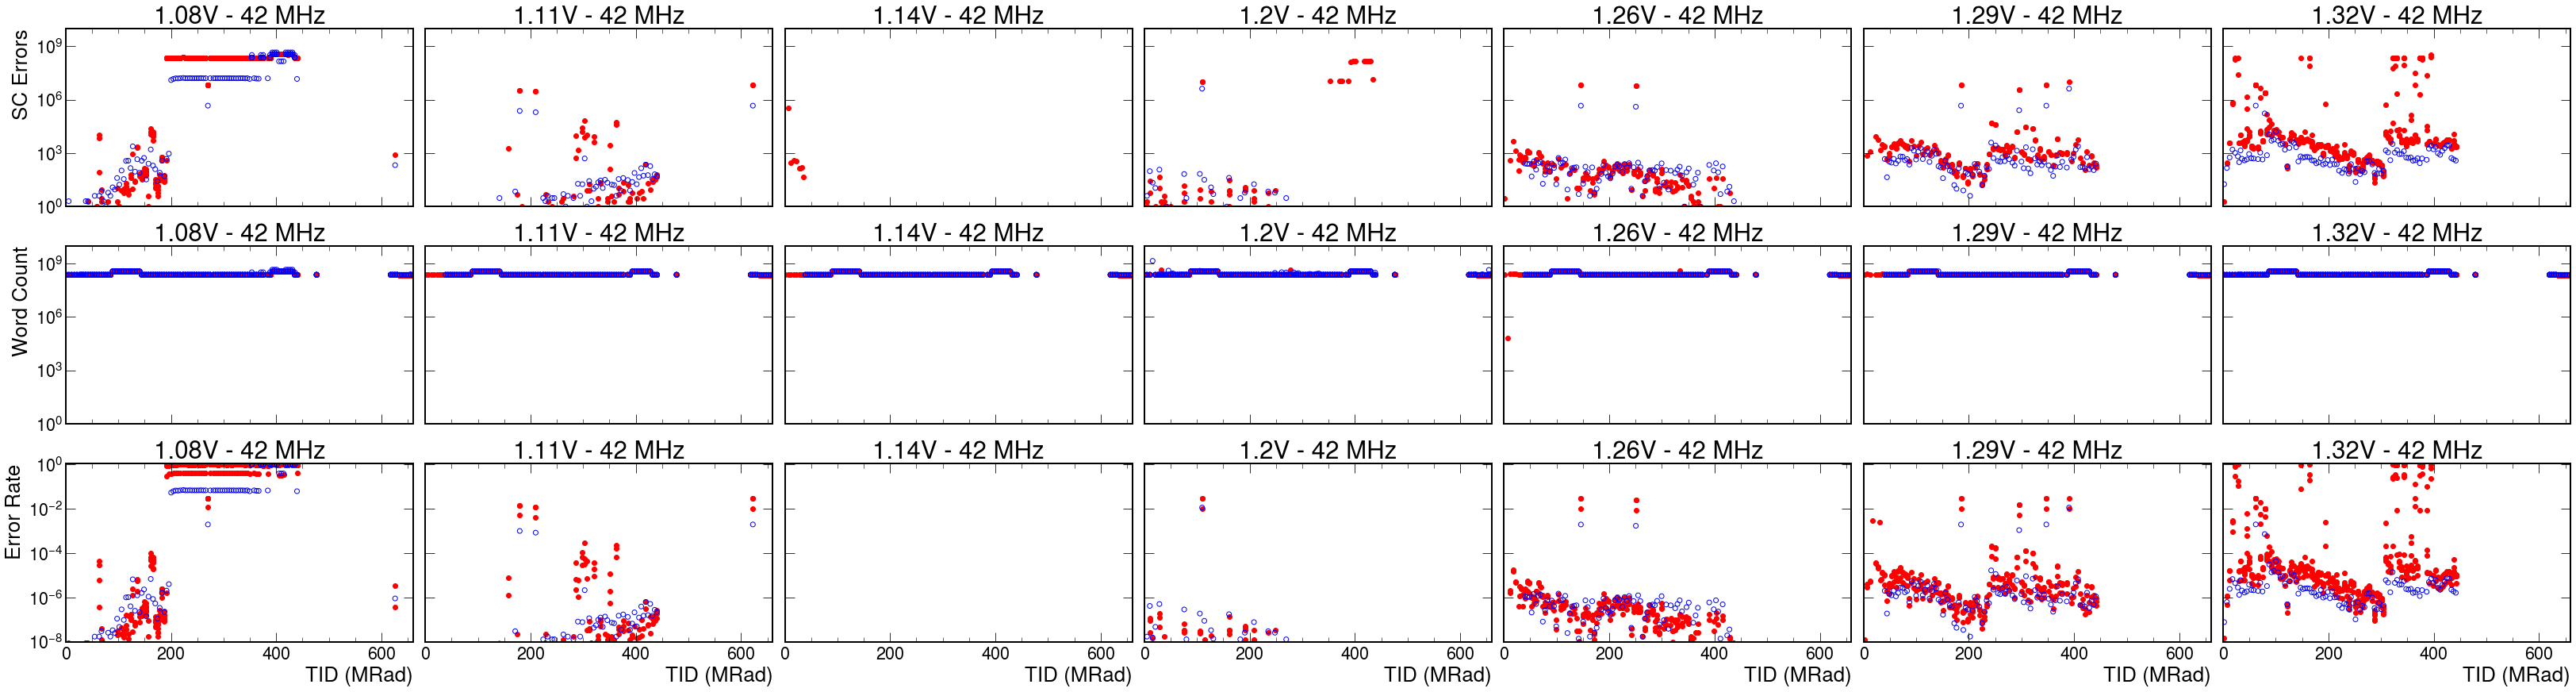

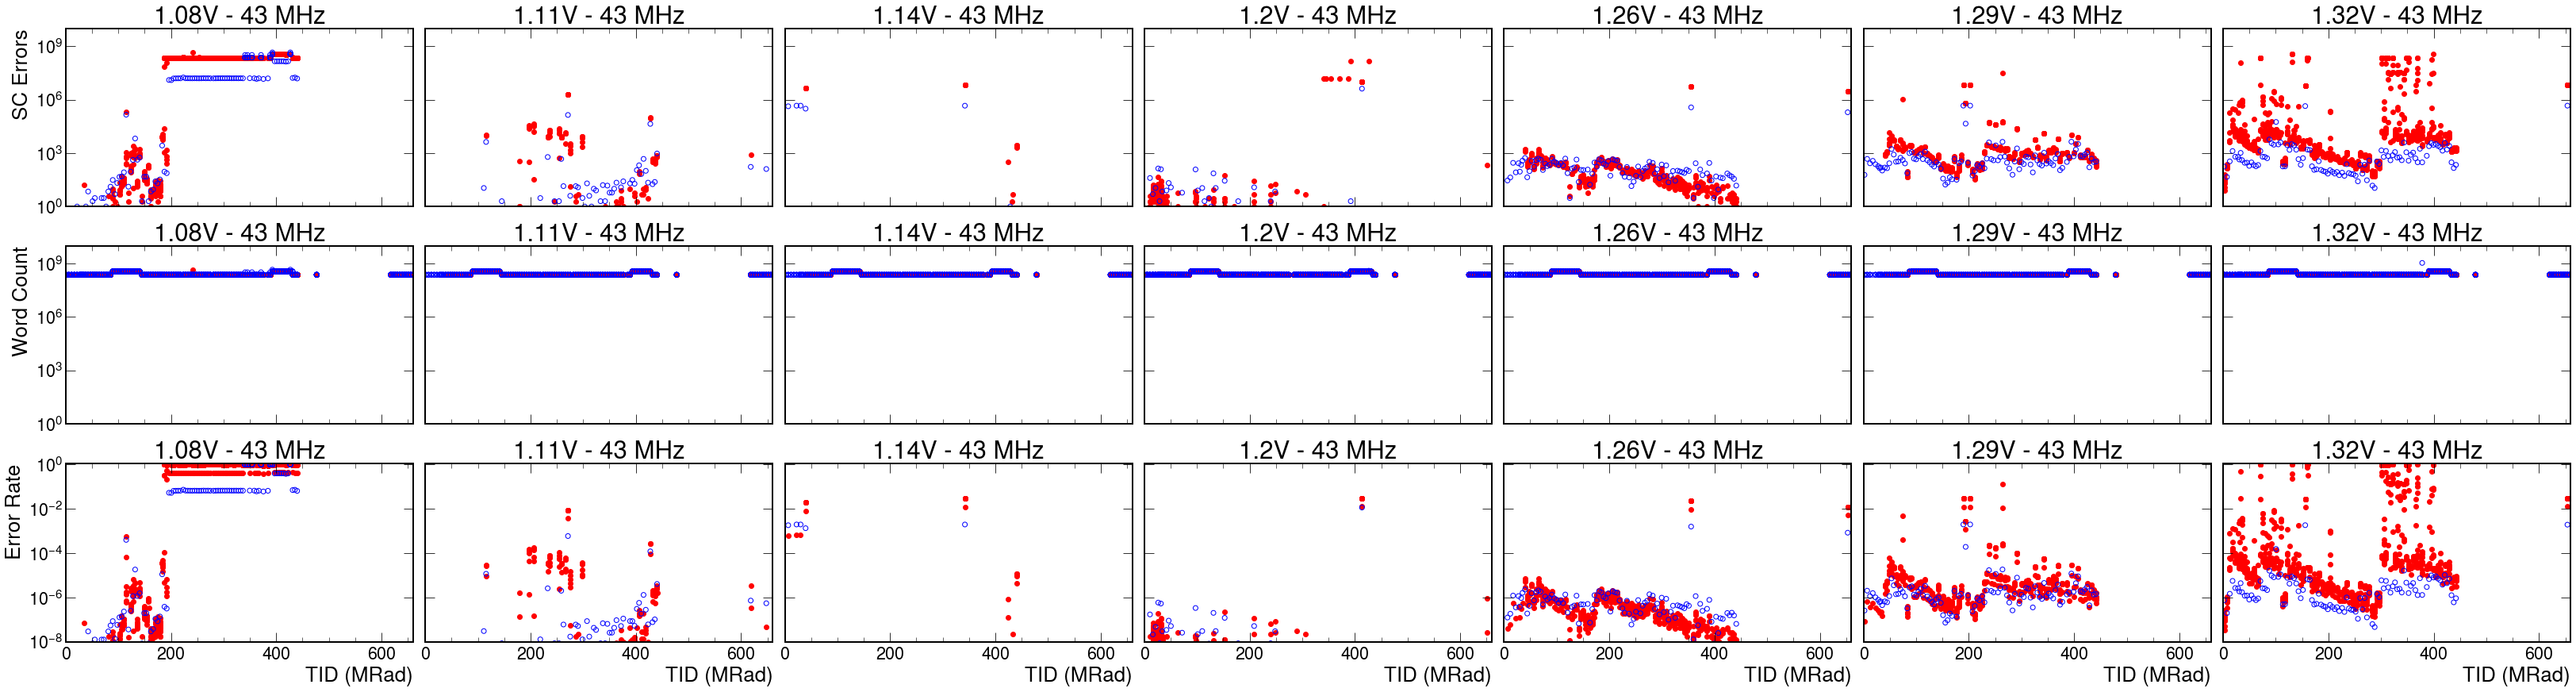

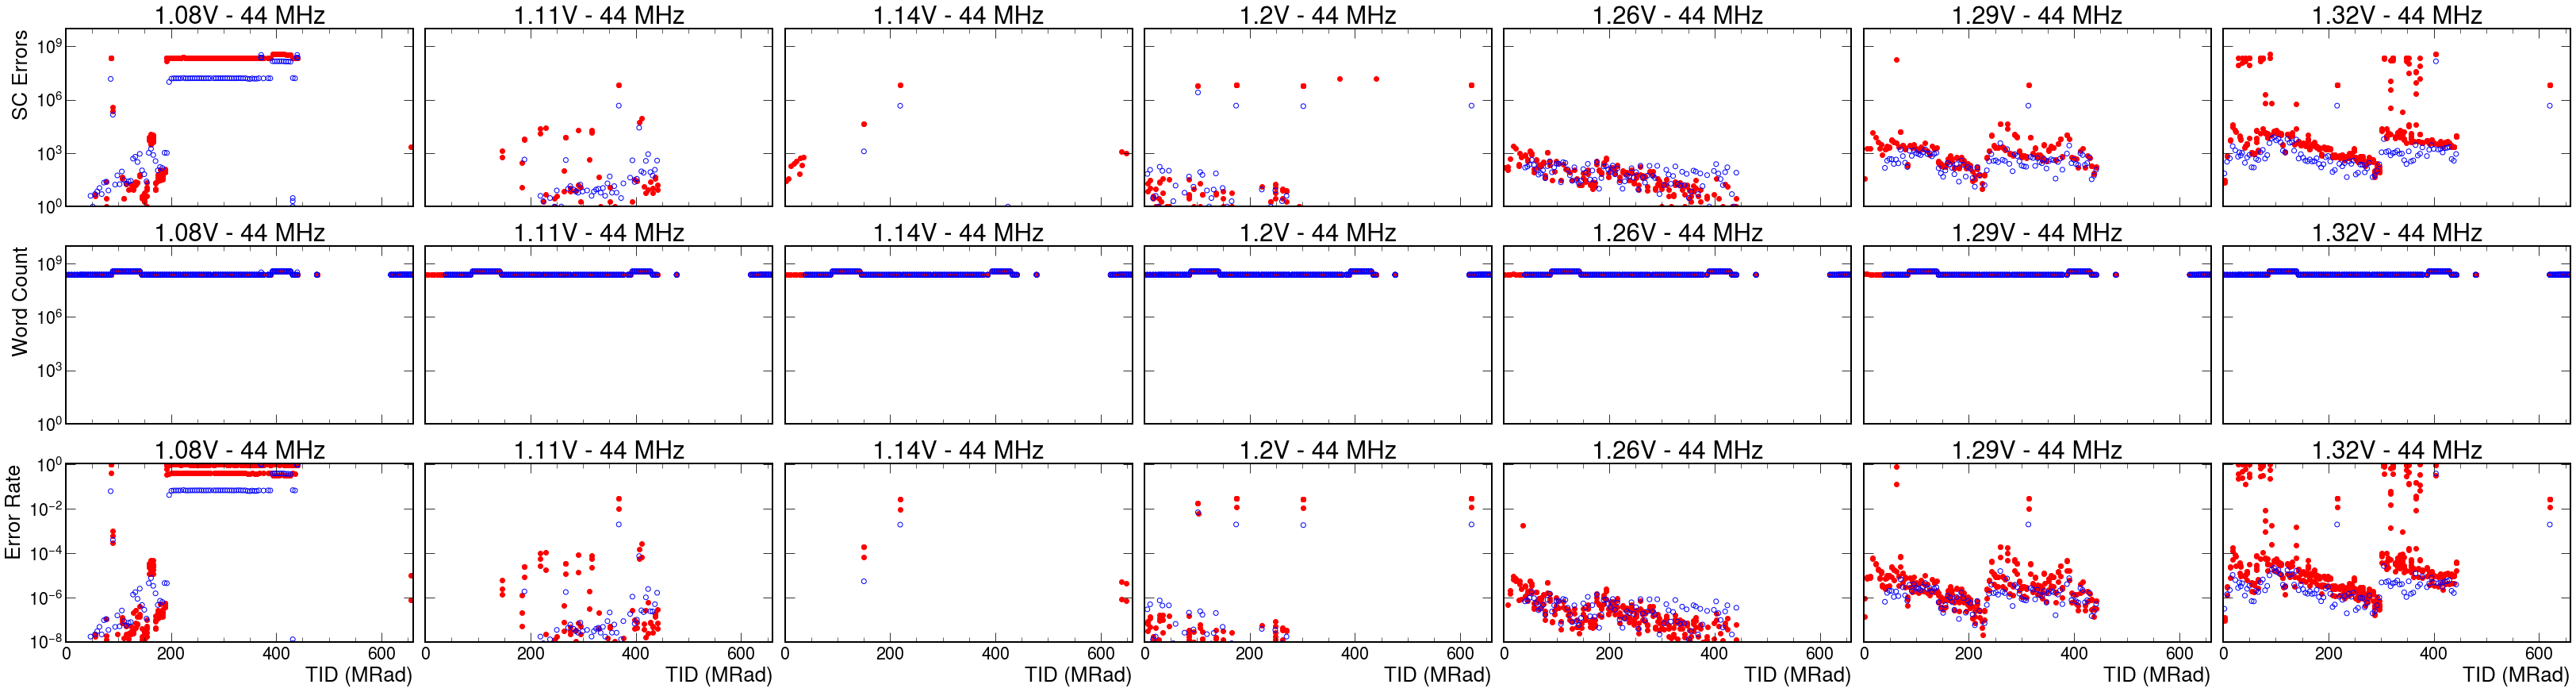

In [90]:
for freq in [42,43,44]:
    error_count(freq)